In [1]:
# Sean Dougherty
# 15/5/2022
# ppc_agn_merger.py analysis notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1

import scipy.stats.distributions as dist

from time import sleep
from tqdm import tqdm

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table
gamma = 1.4
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # 0.7 for omega

import pickle

from scipy.stats import distributions
from scipy.interpolate import interp1d
import scipy

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

PATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/'

## PPC at different 2sigma cuts

In [ ]:
# # read in results
sig_cut = 10
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
rdf

In [ ]:
# # add an AGN count per pair column:
# rdf['mAGN'] = [0]*len(rdf)

# LX_AGN = 10**42
# rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
# rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

In [ ]:
# calculate AGN fractions:

# create bins:
max_dist=100
n_bins=8
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

AGN_frac = {}
dif_cuts = {}
iso_count = {}
PDF_width = {}
sig_cuts = [10,3,2,1,0.5,0.25]
# sig_cuts = [1,0.5,0.25]


for sig_cut in sig_cuts:
    rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
    # add an AGN count per pair column:
    rdf['mAGN'] = [0]*len(rdf)

    LX_AGN = 10**42
    rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    
    PDF_width[str(sig_cut)] = np.zeros(len(bins))

    # split data frame up into each bin
    for i, rnge in enumerate(bins):
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])

        # sort into bins
        bin_df = rdf[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) & (rdf['field'] != 'COS') & (rdf['field'] != 'COSMOS') ]

        # calculating AGN per pair here
        AGN_frac[bins[rnge]] = sum(bin_df['pair_prob'] * bin_df['mAGN']) / (sum(bin_df['pair_prob'])) #* len(bin_df))
        PDF_width[str(sig_cut)][i] = np.mean( np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig'])) ) 

    # get graphical data
    pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
    kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

    dif_cuts[str(sig_cut)] = pAGN_fracs
    iso_count[str(sig_cut)] = len(rdf) / sum(rdf['iso_count'].unique())

In [ ]:
def make_bins_PDF(max_dist=100, n_bins=10):

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

In [ ]:
# # well this didn't work bc no data but it should've
# # get graphical data
# pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
# kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

In [ ]:
# # plot results:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
# ax.scatter(kpc_meds, pAGN_fracs)
# ax.set_xlim(0,100)
# plt.show()

In [ ]:
# PDF_width

In [ ]:
# dif_cuts[str(sig_cut)] = pAGN_fracs
# iso_count[str(sig_cut)] = len(rdf) / sum(rdf['iso_count'].unique())
# marker = ['^','o','X','s','*','d'] * 8
# markers = np.transpose(np.reshape(marker, (8,3)))
kpcs = np.zeros((3,8))
for i in range(0,len(kpcs)):
    kpc_medu = [km+i for km in kpc_meds]
    kpcs[i] = kpc_medu
dif_cut = np.array([dif_cuts[key] for key in dif_cuts])
PDF_wid = np.array([PDF_width[key] for key in PDF_width])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
# ax.scatter(kpcs, dif_cut, s=100, c=PDF_wid)#, marker=markers)
# ax.set_ylim(0,0.12)
# ax.set_xlabel('kpc')
# ax.set_ylabel('AGN fraction')

# marker = ['^','o','X','s','*','d'] * 6
for i, key in enumerate(dif_cuts):
    kpc_medu = [km+i for km in kpc_meds]
    ax.scatter(kpc_medu, dif_cuts[key], s=100, c=PDF_width[key], marker=marker[i], edgecolors='black')
    ax.scatter(-100,-100, marker=marker[i], s=100, edgecolors='black', facecolor='white', label='2$\sigma$ = '+key)
    # ax.set_title('AGN fractions with different $\sigma$ criteria', fontsize=20)
    ax.set_xlim(0,105)
    ax.set_ylim(0,0.1)
    ax.set_xlabel('kpc', fontsize=15)
    ax.set_ylabel('AGN fraction', fontsize=15)
    ax.legend(fontsize=15)
    # cbar = fig.colorbar(pdat, ax=ax[0], vmax=2, vmin=0)
    # cbar.set_label('mean $2\sigma$', fontsize=15)
    # ax[1].bar(float(key), iso_count[key], label='2$\sigma$ = '+key)
    # ax[1].set_title('$N_{pairs} / N_{iso}$')

ax.set_xticks(np.arange(0,100,20))
ax.set_xticklabels(np.arange(0,100,20),fontsize=15)
ax.set_yticks(np.arange(0,0.11,0.02))
ax.set_yticklabels(np.arange(0,0.11,0.02),fontsize=15)

plt.savefig(PATH+'AP_PP_comparing_sigma.png')

plt.show()

## next plot the difference in AGN fraction at different pair_prob cuts


In [ ]:
prob_dat = {}
iso_count = {}
pair_count = {}

In [ ]:
# read in results
sig_cut = 0.25
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')

In [ ]:
# add an AGN count per pair column:
rdf['mAGN'] = [0]*len(rdf)

LX_AGN = 10**42
rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

In [ ]:
# calculate AGN fractions:

# create bins:
max_dist=100
n_bins=8
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

# AGN_frac = {}

probc = [0.9, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001, 0]

AGN_frac = {}
prob_dat = {}
iso_count = {}
pair_count = {}
npairs = {}

# sig_cuts = [10,3,2,1,0.5,0.25]
sig_cuts = [0.5,0.25]

for sig_cut in sig_cuts:
    print(sig_cut)
    rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
    # add an AGN count per pair column:
    rdf['mAGN'] = [0]*len(rdf)
    LX_AGN = 10**42
    rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    
    AGN_frac[str(sig_cut)] = np.zeros((len(probc), n_bins))
    npairs[str(sig_cut)] = np.zeros((len(probc),1))

    for i, p in enumerate(probc):
        rdf2 = rdf.loc[ (rdf['pair_prob'] > p) & (rdf['prime_M'] > 10) & (rdf['field'] != 'COS') & (rdf['field'] != 'COSMOS') ]
        npairs[str(sig_cut)][i] = len(rdf2)

        # split data frame up into each bin
        for j, rnge in enumerate(bins):
            # get bin ranges from bins dictionary entries
            info = bins[rnge].split('-')
            low = float(info[0])
            high = float(info[1])

            # sort into bins
            bin_df = rdf2[ (rdf2['kpc_sep'] > low) & (rdf2['kpc_sep'] <= high) ]

            # calculating AGN per pair here
            AGN_frac[str(sig_cut)][i,j] = (sum(bin_df['pair_prob'] * 0.5*bin_df['mAGN']) / (sum(bin_df['pair_prob'])))# * len(bin_df)))

    kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

    prob_dat = AGN_frac
    iso_count[str(sig_cut)] = sum(rdf['iso_count'].unique())
    pair_count = npairs

In [ ]:
bin_df

In [ ]:
# # get graphical data
# # pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
# kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

# prob_dat[str(sig_cut)] = AGN_frac
# iso_count[str(sig_cut)] = sum(rdf['iso_count'].unique())
# pair_count[str(sig_cut)] = npairs

In [ ]:
# kpc_meds

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharey=True)
fig.subplots_adjust(wspace=0)

for k, key in enumerate(prob_dat):
    for i in range(0,len(prob_dat[key])):
        kpc_medu = [km+(i*1) for km in kpc_meds]
        ax[k].scatter(kpc_medu, prob_dat[key][i], label='$\mathcal{N}_z$ < '+str(probc[i]), s=50)
    #ax[k].set_ylim(0,8e-5)
    ax[k].set_ylim(0,0.12)
    ax[k].set_xlim(-5,105)
    ax[k].set_title('2$\sigma$ < '+key, fontsize=20)
    ax[k].legend(fontsize=15, ncol=2, loc='lower left')
    
ax[0].set_xticks(np.arange(0,105,20))
ax[0].set_xticklabels(np.arange(0,105,20),fontsize=15)
ax[0].set_yticks(np.arange(0,0.12,0.02))
ax[0].set_yticklabels(np.arange(0,0.12,0.02),fontsize=15)

ax[0].set_xlabel('projected separation (kpc)', fontsize=15)
ax[1].set_xlabel('projected separation (kpc)', fontsize=15)
ax[0].set_ylabel('AGN fraction', fontsize=15)


ax[1].set_xticks(np.arange(0,105,20))
ax[1].set_xticklabels(np.arange(0,105,20),fontsize=15)
    
plt.savefig(PATH+'AP_PP_comparing_prob_cuts.png')
    
plt.show()     

### remember this is AGN fraction per pairs ###

## Compare pair and control sample distributions:

In [2]:
# let's put the convolution values together (minus COSMOS)
fields = ['GDS','EGS','COS','GDN','UDS']#,'COSMOS']
# fields = ['COSMOS']
ztype='ps'
Mlo = 9.4
min_pp = 0.1 # waiting for COSMOS to finish for the p P=0.1 group
date='11.2' # 8.25, 9.1, 9.2, 9.5 (COSMOS i_MAG < 25)
bob_type = 'full' # 'full', 'randbob'
dfs = {}
cdfs = {}
PdA_dfs = {}
# PdA_arr = np.zeros((1783360, 1500)) # need to see how long before loading but let's see...

all_len = 0
for field in tqdm(fields):

    # pair data ### _Pp-'+str(min_pp)+'_
    # file = 'conv_prob/conv_output/PAIRS_bob-'+bob_type+'_M-'+str(Mlo)+'_ztype-'+ztype+'_'+field+'_'+date+'.csv'
    file = 'conv_prob/conv_output/PAIRS_Pp-'+str(min_pp)+'_bob-'+bob_type+'_M-'+str(Mlo)+'_ztype-'+ztype+'_'+field+'_'+date+'.csv'
    dfs[field] = pd.read_csv(PATH+file)
    
    # PdA arrays
    # with fits.open(PATH+'conv_prob/PdA_output/PdA_bob-'+bob_type+'_M-'+str(Mlo)+'_ztype-'+ztype+'_'+field+'_'+date+'.fits') as data:
    with fits.open(PATH+'conv_prob/PdA_output/PdA_Pp-'+str(min_pp)+'_bob-'+bob_type+'_M-'+str(Mlo)+'_ztype-'+ztype+'_'+field+'_'+date+'.fits') as data:
        PdA_dfs[field] = pd.DataFrame(data[0].data)
        
    # control data:
    # cfile = 'conv_prob/control_output/APPLES_bob-'+bob_type+'_M-'+str(Mlo)+'_N-2_ztype-'+ztype+'_'+field+'_'+date+'.csv'
    cfile = 'conv_prob/control_output/APPLES_Pp-'+str(min_pp)+'_bob-'+bob_type+'_M-'+str(Mlo)+'_N-3_ztype-'+ztype+'_'+field+'_'+date+'.csv'
    cdfs[field] = pd.read_csv(PATH+cfile)

# dA = np.linspace(0, 200, num=2001)

### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
print('concatinating PdA array... please wait.')
PdA_df = pd.concat(PdA_dfs).reset_index(drop=True)
PdA_arr = np.array(PdA_df)[:,2:] # hopefully this doesn't take ages...
print('Done. Thanks for waiting!')
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

# PdA_arr = np.concatenate(( np.array(PdA_df)[:,2:], np.array(PdA_df)[:,2:] ))

# PdA_arr = np.concatenate(( np.array(PdA_df)[:,2:], np.array(PdA_df)[:,2:] )) # for use_PdA True
### This will take a good chunk of time... ^^^
                            
### ~~~ WILL NEED TO THINK HOW TO INCORPORATE THE ACTUAL REDSHIFT THE PAIR WOULD OVER LAP AT ~~~ ###
                            # SIMPLY IN TERMS OF BINNING #
### ~~~ MIGHT ALSO WANTTO CONIDER PUTTING THE dA ARRAY INTO THE PdA FILE SOMEHOW ~~~ ###


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


concatinating PdA array... please wait.
Done. Thanks for waiting!


In [25]:
# 9.1 == EAZY
# 9.2 == LEPHARE

In [3]:
def make_bins_PDF(max_dist=100, n_bins=10):

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

In [7]:
# define a function to find the median (any percentiles) of a weighted histogram
def perc_wei_hist(arr, arr_wei, percs):
    # sort the array accordingly:
    sort_idx = np.argsort(arr)
    sort_arr = arr[sort_idx]
    sort_probs = arr_wei[sort_idx]
    arr_tot = np.sum(sort_probs)
    arr_perc = []
    for perc in percs:
        # want to sum up the probs until they reach the perc:
        perc_count = (perc/100) * arr_tot
        pcount = 0
        i = 0
        while pcount < perc_count:
            pcount = np.sum(sort_probs[:i])
            i+=1
        arr_perc.append(sort_arr[i])
        
    return arr_perc

def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)


def bootstrap(obs, weights, n_boots=100):
    if np.sum(weights) != 1:
        weights = weights / np.sum(weights)
    boot_mean = np.zeros(n_boots)
    for i in range(n_boots):
        boot_d = np.random.choice(obs, size=len(np.where(weights>1e-6)[0]), replace=True, p=weights)
        boot_mean[i] = np.mean(boot_d)
    return np.sqrt(np.var(boot_mean))


In [27]:
np.sum(maj_lowLX_PdA),
np.sum(maj_hiLX_PdA)

129880.00000000001

In [29]:
# create bins:
max_dist=100
n_bins=5
resolve = False
use_PdA = True # resolving in this case is pointless, so don't worry about that switch when this one is on
maj_mr = np.log10(4) # major mergers
min_mr = 1
bottom = 0
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)
# PdA_arr = np.array(PdA_df)[:,2:] # hopefully this doesn't take ages...
dA = np.linspace(0, 200, num=2001)
lowLX = 42
midLX = 43.2
hiLX = 43.7

# combine the dataframes
rdf = pd.concat(dfs).reset_index(drop=True)
cdf = pd.concat(cdfs).reset_index(drop=True)
# cdf = cdf.rename(columns={'ID1':'ID0', 'MASS1':'MASS0', 'z1':'z0', 'LX1':'LX0', 'IR_AGN_DON1':'IR_AGN_DON0', 'IR_AGN_STR1':'IR_AGN_STR0',
#          'ID2':'ID1', 'MASS2':'MASS1', 'z2':'z1', 'LX2':'LX1', 'IR_AGN_DON2':'IR_AGN_DON1', 'IR_AGN_STR2':'IR_AGN_STR1'})

# no just match based on pair ID strings as so
rdf['pair_ID'] = rdf['field'] +'_'+ (rdf['prime_ID'].astype(int)).astype(str) +'+'+ (rdf['partner_ID'].astype(int)).astype(str)
cdf['pair_ID'] = cdf['field'] +'_'+ (cdf['P_ID1'].astype(int)).astype(str) +'+'+ (cdf['P_ID2'].astype(int)).astype(str)
cdf['apple_ID'] = cdf['field'] +'_'+ (cdf['ID1'].astype(int)).astype(str) +'+'+ (cdf['ID2'].astype(int)).astype(str)

# get the N_controls selected from bobbing method:
N_controls = 3 #int(cfile.split('/')[-1].split('_')[1][2]) # should work, also don't need to do things this way

# add an AGN count per pair column:
rdf['lowX_1'] = [0]*len(rdf)
rdf['lowX_2'] = [0]*len(rdf)
rdf['midX_1'] = [0]*len(rdf)
rdf['midX_2'] = [0]*len(rdf)
rdf['hiX_1'] = [0]*len(rdf)
rdf['hiX_2'] = [0]*len(rdf)
rdf['X_1'] = [0]*len(rdf)
rdf['X_2'] = [0]*len(rdf)
rdf['IR_1'] = [0]*len(rdf)
rdf['IR_2'] = [0]*len(rdf)
# rdf['poDoAGN_1'] = [0]*len(rdf)
# rdf['poDoAGN_2'] = [0]*len(rdf)
rdf.loc[ (np.log10(rdf['prime_LX']) > lowLX) & (np.log10(rdf['prime_LX']) < midLX), 'lowX_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > lowLX) & (np.log10(rdf['partner_LX']) < midLX), 'lowX_2' ] = 1
rdf['lowLX'] = rdf['lowX_1'] + rdf['lowX_2']
rdf.loc[ (np.log10(rdf['prime_LX']) > midLX) & (np.log10(rdf['prime_LX']) < hiLX), 'midX_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > midLX) & (np.log10(rdf['partner_LX']) < hiLX), 'midX_2' ] = 1
rdf['midLX'] = rdf['midX_1'] + rdf['midX_2']
rdf.loc[ (np.log10(rdf['prime_LX']) > hiLX), 'hiX_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > hiLX), 'hiX_2' ] = 1
rdf['hiLX'] = rdf['hiX_1'] + rdf['hiX_2']
rdf.loc[ (np.log10(rdf['prime_LX']) > lowLX), 'X_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > lowLX), 'X_2' ] = 1
rdf['allLX'] = rdf['X_1'] + rdf['X_2']
rdf.loc[ rdf['prime_IR_AGN_DON'] == 1, 'IR_1' ] = 1
rdf.loc[ rdf['partner_IR_AGN_DON'] == 1, 'IR_2' ] = 1
rdf['IR'] = rdf['IR_1'] + rdf['IR_2']
# rdf.loc[ (rdf['pDoAGN_1'] == 1) & (rdf['pXAGN_1'] != 1), 'poDoAGN_1' ] = 1
# rdf.loc[ (rdf['pDoAGN_2'] == 1) & (rdf['pXAGN_2'] != 1), 'poDoAGN_2' ] = 1

cdf['lowX_1'] = [0]*len(cdf)
cdf['lowX_2'] = [0]*len(cdf)
cdf['midX_1'] = [0]*len(cdf)
cdf['midX_2'] = [0]*len(cdf)
cdf['hiX_1'] = [0]*len(cdf)
cdf['hiX_2'] = [0]*len(cdf)
cdf['X_1'] = [0]*len(cdf)
cdf['X_2'] = [0]*len(cdf)
cdf['IR_1'] = [0]*len(cdf)
cdf['IR_2'] = [0]*len(cdf)
cdf.loc[ (np.log10(cdf['LX1']) > lowLX) & (np.log10(cdf['LX1']) < midLX), 'lowX_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > lowLX) & (np.log10(cdf['LX2']) < midLX), 'lowX_2' ] = 1
cdf['lowLX'] = cdf['lowX_1'] + cdf['lowX_2']
cdf.loc[ (np.log10(cdf['LX1']) > midLX) & (np.log10(cdf['LX1']) < hiLX), 'midX_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > midLX) & (np.log10(cdf['LX2']) < hiLX), 'midX_2' ] = 1
cdf['midLX'] = cdf['midX_1'] + cdf['midX_2']
cdf.loc[ (np.log10(cdf['LX1']) > hiLX), 'hiX_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > hiLX), 'hiX_2' ] = 1
cdf['hiLX'] = cdf['hiX_1'] + cdf['hiX_2']
cdf.loc[ (np.log10(cdf['LX1']) > lowLX), 'X_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > lowLX), 'X_2' ] = 1
cdf['allLX'] = cdf['X_1'] + cdf['X_2']
cdf.loc[ cdf['IR_AGN_DON1'] == 1, 'IR_1' ] = 1
cdf.loc[ cdf['IR_AGN_DON2'] == 1, 'IR_2' ] = 1
cdf['IR'] = cdf['IR_1'] + cdf['IR_2']
# cdf.loc[ (cdf['iDoAGN_1'] == 1) & (cdf['iXAGN_1'] != 1), 'ioDoAGN_1' ] = 1
# cdf.loc[ (cdf['iDoAGN_2'] == 1) & (cdf['iXAGN_2'] != 1), 'ioDoAGN_2' ] = 1

##########################################################################
### --- get all cuts here --- ############################################
### --- perhaps a dictionary of dictionaries for the results --- #########
### --- lowLX                                                    #########
### --- midLX                                                    #########
### --- hiLX { maj, majmin, min } # maj results for each bin.... ######### 
### --- IR                                                       #########
### --- I need to save count, frac, and se for each of these     #########
##########################################################################

major, minor, major_minor = {},{},{}
data = ['count','frac','se']
AGN_type = ['lowLX','midLX','hiLX','allLX','IR', 'ilowLX','imidLX','ihiLX','iallLX','iIR']
for AGN in AGN_type:
    for dat in data:
        major[AGN+'_'+dat] = {}
        minor[AGN+'_'+dat] = {}
        major_minor[AGN+'_'+dat] = {}

# store total counts
tot_pair, tot_iso, bin_dfs = {},{},{} # to look at dfs in post

# IRAX flux errors
pCH1_ABmag_bin, pCH2_ABmag_bin, pCH3_ABmag_bin, pCH4_ABmag_bin = {},{},{},{}
iCH1_ABmag_bin, iCH2_ABmag_bin, iCH3_ABmag_bin, iCH4_ABmag_bin = {},{},{},{}

pboot_Xse, iboot_Xse = {}, {}
pboot_IRse, iboot_IRse = {}, {}

p_probs, i_probs, p_wprobs, i_wprobs, P_W, I_W = {},{},{},{},{},{}
ID_bin, field_bin, iID_bin, ifield_bin = {},{},{},{}
c_dfd = {} # dictionary of dataframes for each bin for the control galaxy selection
pz_bin, pmass_bin, psig_bin, penv_bin = {},{},{},{}
iz_bin, imass_bin, isig_bin, ienv_bin = {},{},{},{}

pX_bin, pDo_bin, poDo_bin, pSt_bin = {},{},{},{}
iX_bin, iDo_bin, ioDo_bin, iSt_bin = {},{},{},{}

# collect distribution of entire data
pz = np.concatenate( (rdf['prime_z'], rdf['partner_z']) )
pmass = np.concatenate( (rdf['prime_M'], rdf['partner_M']) )
psig = np.concatenate( (rdf['prime_PDFsig'], rdf['partner_PDFsig']) ) # no longer care about this
penv = np.concatenate( (rdf['prime_env'], rdf['partner_env']) )

iz = np.concatenate( (cdf['z1'], cdf['z2']) )
imass = np.concatenate( (cdf['MASS1'], cdf['MASS2']) )
ienv = np.concatenate( (cdf['ENV1'], cdf['ENV2']) )
# isig = ...

# ### perhaps I should define these always ... ###
# rdf = rdf.loc[ (rdf['prime_M'] > 10) & (rdf['prime_z'] < 3) & (rdf['field'] != 'COSMOS') & #| (rdf['field'] == 'COS')) &
#           (rdf['pair_prob'] > bottom) & (rdf['mass_ratio'] < mass_ratio) ]
# # no just match based on pair ID strings as so
# cdf = cdf.loc[ (cdf['pair_ID'].isin(rdf['pair_ID']) == True) ]


def bin_analysis(bin_df, ibin_df, PdA_arr, low, high, prime_mass_lo, prime_z_lo, prime_z_hi, 
                   mr_lo, mr_hi, fields, AGN_type, p_lo=0, N_controls=N_controls):
    
    dA = np.linspace(0, 200, num=2001)
    
    df = bin_df.loc[ (bin_df['prime_M'] > prime_mass_lo) & (bin_df['pair_prob'] > p_lo) & 
                              (bin_df['prime_z'] > prime_z_lo) & (bin_df['prime_z'] < prime_z_hi) &
                              (bin_df['mass_ratio'] > mr_lo) & (bin_df['mass_ratio'] < mr_hi) &
                             (bin_df['field'].isin(fields) == True) ]
    PdA = PdA_arr[df.index]
    Pr = np.trapz(PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    PP = np.array(df['pair_prob']) * Pr[:,0]
    obs = np.array(df[AGN_type])
    count =  np.sum(PP * obs)
    PPn = PP / np.sum(PP)
    frac = np.sum(obs * PPn)
    se = bootstrap(obs, PPn)
    
    idf = ibin_df.loc[ (ibin_df['pair_ID'].isin(df['pair_ID']) == True) ]
    iPP = np.array(idf['Cp'])*np.repeat(Pr[:,0], N_controls)
    iobs = np.array(idf[AGN_type])
    icount = np.sum(iPP * iobs)
    iPPn = iPP / np.sum(iPP)
    ifrac = np.sum(iobs * iPPn)  
    ise = bootstrap(iobs, iPPn)
    
    return count, frac, se, icount, ifrac, ise
    


# split data frame up into each bin
for i, rnge in enumerate(bins):
    # get bin ranges from bins dictionary entries
    info = bins[rnge].split('-')
    low = float(info[0])
    high = float(info[1])
    
    bin_df = rdf  #[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) & (rdf['kpc_sep'] > 4) ]
    # bin_df = rdf[ (rdf['kpc_sep'] > 3) ]
    ibin_df = cdf.loc[ (cdf['pair_ID'].isin(bin_df['pair_ID']) == True) ]
#     bin_dfs[bins[rnge]] = bin_df           ### ~~~ WILL NEED TO UPDATE THE PROBABILITIES FOR CONTROL SELECTION ~~~ ###

#     bin_ID = np.concatenate((bin_df['prime_ID'], bin_df['partner_ID']))
#     bin_field = np.concatenate((bin_df['field'], bin_df['field']))
#     bin_probs = np.concatenate((bin_df['pair_prob'], bin_df['pair_prob']))
#     bin_pz = np.concatenate((bin_df['prime_z'], bin_df['partner_z']))
#     bin_pm = np.concatenate((bin_df['prime_M'], bin_df['partner_M']))
#     bin_env = np.concatenate((bin_df['prime_env'], bin_df['partner_env']))
#     bin_psig = np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig']))
#     bin_XAGN = np.concatenate((bin_df['pXAGN_1'], bin_df['pXAGN_2']))
#     bin_DoAGN = np.concatenate((bin_df['pDoAGN_1'], bin_df['pDoAGN_2']))
#     bin_oDoAGN = np.concatenate((bin_df['poDoAGN_1'], bin_df['poDoAGN_2']))
#     bin_StAGN = np.concatenate((bin_df['pStAGN_1'], bin_df['pStAGN_2']))
#     bin_CH1_ABmag = np.concatenate((bin_df['prime_CH1_ABMAG'], bin_df['partner_CH1_ABMAG']))
#     bin_CH2_ABmag = np.concatenate((bin_df['prime_CH2_ABMAG'], bin_df['partner_CH2_ABMAG']))
#     bin_CH3_ABmag = np.concatenate((bin_df['prime_CH3_ABMAG'], bin_df['partner_CH3_ABMAG']))
#     bin_CH4_ABmag = np.concatenate((bin_df['prime_CH4_ABMAG'], bin_df['partner_CH4_ABMAG']))
#     ibin_ID = np.concatenate((ibin_df['ID1'], ibin_df['ID2']))
#     ibin_field = np.concatenate((ibin_df['field'], ibin_df['field']))
#     ibin_probs = np.concatenate((ibin_df['Cp'], ibin_df['Cp']))
#     ibin_z = np.concatenate((ibin_df['z1'], ibin_df['z2']))
#     ibin_m = np.concatenate((ibin_df['MASS1'], ibin_df['MASS2']))
#     ibin_env = np.concatenate((ibin_df['ENV1'], ibin_df['ENV2']))
#     ibin_psig = np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig']))
#     ibin_XAGN = np.concatenate((ibin_df['iXAGN_1'], ibin_df['iXAGN_2']))
#     ibin_DoAGN = np.concatenate((ibin_df['iDoAGN_1'], ibin_df['iDoAGN_2']))
#     ibin_oDoAGN = np.concatenate((ibin_df['ioDoAGN_1'], ibin_df['ioDoAGN_2']))
#     ibin_StAGN = np.concatenate((ibin_df['iStAGN_1'], ibin_df['iStAGN_2']))
#     ibin_CH1_ABmag = np.concatenate((ibin_df['IRAC_CH1_ABMAG1'], ibin_df['IRAC_CH1_ABMAG2']))
#     ibin_CH2_ABmag = np.concatenate((ibin_df['IRAC_CH2_ABMAG1'], ibin_df['IRAC_CH2_ABMAG2']))
#     ibin_CH3_ABmag = np.concatenate((ibin_df['IRAC_CH3_ABMAG1'], ibin_df['IRAC_CH3_ABMAG2']))
#     ibin_CH4_ABmag = np.concatenate((ibin_df['IRAC_CH4_ABMAG1'], ibin_df['IRAC_CH4_ABMAG2']))

#     bin_PdA = PdA_arr[rdf.index] # may need to be bin_df.index, but no difference obv
    if i == 0: # should be the closest bin
        low = 5

#     bin_weights = np.trapz(bin_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
#     bin_weights2 = np.concatenate((bin_weights[:,0], bin_weights[:,0])) # may need to concatenate bin_weights[:,0]
#     # gonna need this for iso probs too
#     bin_wei_probs = bin_probs*bin_weights2
#     ibin_wei_probs = ibin_probs*np.repeat(bin_weights2, N_controls)

    ###############################################################################
    ############ -- GET WEIGHTS WITHOUT SPLITTING EVERYTHING UP TOO -- ############
    ###############################################################################
    
    ### ----------------------------------- ###
    ### ----------------------------------- ### MAJOR
    ### ----------------------------------- ###
    
    # try if my function works for maj low_LX:
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, 0.5, 2,
                          0, np.log10(4), ['GDS','GDN'], 'lowLX')
    major['lowLX_count'][bins[rnge]] = results[0]
    
    
    
    # def bin_analysis(bin_df, ibin_df, PdA_arr, low, high, prime_mass_lo, prime_z_lo, prime_z_hi, 
    #                mr_lo, mr_hi, fields, AGN_type, p_lo=0, N_controls=N_controls):
        
        

    maj_lowLX_df = bin_df.loc[ (bin_df['prime_M'] > 10) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 2) & (bin_df['mass_ratio'] < maj_mr) &
                             ((bin_df['field'] == 'GDS') | (bin_df['field'] == 'GDN')) ]
    maj_lowLX_PdA = PdA_arr[maj_lowLX_df.index]
    maj_lowLX_Pr = np.trapz(maj_lowLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    maj_lowLX_PP = np.array(maj_lowLX_df['pair_prob']) * maj_lowLX_Pr[:,0]
    maj_lowLX = np.array(maj_lowLX_df['lowLX'])
    major['lowLX_count'][bins[rnge]] =  np.sum(maj_lowLX_PP * maj_lowLX)
    maj_lowLX_PPn = maj_lowLX_PP / np.sum(maj_lowLX_PP)
    major['lowLX_frac'][bins[rnge]] = np.sum(maj_lowLX * maj_lowLX_PPn)
    major['lowLX_se'][bins[rnge]] = bootstrap(maj_lowLX, maj_lowLX_PPn)
    # ------
    imaj_lowLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(maj_lowLX_df['pair_ID']) == True) ]
    imaj_lowLX_PP = np.array(imaj_lowLX_df['Cp'])*np.repeat(maj_lowLX_Pr[:,0], N_controls)
    imaj_lowLX = np.array(imaj_lowLX_df['lowLX'])
    major['ilowLX_count'][bins[rnge]] = np.sum(imaj_lowLX_PP * imaj_lowLX)
    imaj_lowLX_PPn = imaj_lowLX_PP / np.sum(imaj_lowLX_PP)
    major['ilowLX_frac'][bins[rnge]] = np.sum(imaj_lowLX * imaj_lowLX_PPn)  
    major['ilowLX_se'][bins[rnge]] = bootstrap(imaj_lowLX, imaj_lowLX_PPn)
    # ------ 
    # ------
    maj_midLX_df = bin_df.loc[ (bin_df['prime_M'] > 10) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 2) & (bin_df['mass_ratio'] < maj_mr) ]
    maj_midLX_PdA = PdA_arr[maj_midLX_df.index]
    maj_midLX_Pr = np.trapz(maj_midLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    maj_midLX_PP = np.array(maj_midLX_df['pair_prob']) * maj_midLX_Pr[:,0]
    maj_midLX = np.array(maj_midLX_df['midLX'])
    major['midLX_count'][bins[rnge]] =  np.sum(maj_midLX_PP * maj_midLX)
    maj_midLX_PPn = maj_midLX_PP / np.sum(maj_midLX_PP)
    major['midLX_frac'][bins[rnge]] = np.sum(maj_midLX * maj_midLX_PPn)
    major['midLX_se'][bins[rnge]] = bootstrap(maj_midLX, maj_midLX_PPn)
    # ------
    imaj_midLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(maj_midLX_df['pair_ID']) == True) ]
    imaj_midLX_PP = np.array(imaj_midLX_df['Cp'])*np.repeat(maj_midLX_Pr[:,0], N_controls)
    imaj_midLX = np.array(imaj_midLX_df['midLX'])
    major['imidLX_count'][bins[rnge]] = np.sum(imaj_midLX_PP * imaj_midLX)
    imaj_midLX_PPn = imaj_midLX_PP / np.sum(imaj_midLX_PP)
    major['imidLX_frac'][bins[rnge]] = np.sum(imaj_midLX * imaj_midLX_PPn)
    major['imidLX_se'][bins[rnge]] = bootstrap(imaj_midLX, imaj_midLX_PPn)
    # ------
    # ------
    maj_hiLX_df = bin_df.loc[ (bin_df['prime_M'] > 10) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 3) & (bin_df['mass_ratio'] < maj_mr) ]
    maj_hiLX_PdA = PdA_arr[maj_hiLX_df.index]
    maj_hiLX_Pr = np.trapz(maj_hiLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    maj_hiLX_PP = np.array(maj_hiLX_df['pair_prob']) * maj_hiLX_Pr[:,0]
    maj_hiLX = np.array(maj_hiLX_df['hiLX'])
    major['hiLX_count'][bins[rnge]] =  np.sum(maj_hiLX_PP * maj_hiLX)
    maj_hiLX_PPn = maj_hiLX_PP / np.sum(maj_hiLX_PP)
    major['hiLX_frac'][bins[rnge]] = np.sum(maj_hiLX * maj_hiLX_PPn)
    major['hiLX_se'][bins[rnge]] = bootstrap(maj_hiLX, maj_hiLX_PPn)
    # ------
    imaj_hiLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(maj_hiLX_df['pair_ID']) == True) ]
    imaj_hiLX_PP = np.array(imaj_hiLX_df['Cp'])*np.repeat(maj_hiLX_Pr[:,0], N_controls)
    imaj_hiLX = np.array(imaj_hiLX_df['hiLX'])
    major['ihiLX_count'][bins[rnge]] = np.sum(imaj_hiLX_PP * imaj_hiLX)
    imaj_hiLX_PPn = imaj_hiLX_PP / np.sum(imaj_hiLX_PP)
    major['ihiLX_frac'][bins[rnge]] = np.sum(imaj_hiLX * imaj_hiLX_PPn)
    major['ihiLX_se'][bins[rnge]] = bootstrap(imaj_hiLX, imaj_hiLX_PPn)
    # ------
    # ------ ALL LX
    maj_allLX_df = bin_df.loc[ (bin_df['prime_M'] > 10) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 3) & (bin_df['mass_ratio'] < maj_mr) ]
    maj_allLX_PdA = PdA_arr[maj_allLX_df.index]
    maj_allLX_Pr = np.trapz(maj_allLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    maj_allLX_PP = np.array(maj_allLX_df['pair_prob']) * maj_allLX_Pr[:,0]
    maj_allLX = np.array(maj_allLX_df['allLX'])
    major['allLX_count'][bins[rnge]] =  np.sum(maj_allLX_PP * maj_allLX)
    maj_allLX_PPn = maj_allLX_PP / np.sum(maj_allLX_PP)
    major['allLX_frac'][bins[rnge]] = np.sum(maj_allLX * maj_allLX_PPn)
    major['allLX_se'][bins[rnge]] = bootstrap(maj_allLX, maj_allLX_PPn)
    # ------
    imaj_allLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(maj_allLX_df['pair_ID']) == True) ]
    imaj_allLX_PP = np.array(imaj_allLX_df['Cp'])*np.repeat(maj_allLX_Pr[:,0], N_controls)
    imaj_allLX = np.array(imaj_allLX_df['allLX'])
    major['iallLX_count'][bins[rnge]] = np.sum(imaj_allLX_PP * imaj_allLX)
    imaj_allLX_PPn = imaj_allLX_PP / np.sum(imaj_allLX_PP)
    major['iallLX_frac'][bins[rnge]] = np.sum(imaj_allLX * imaj_allLX_PPn)
    major['iallLX_se'][bins[rnge]] = bootstrap(imaj_allLX, imaj_allLX_PPn)
    # ------
    # ------
    maj_IR_df = bin_df.loc[ (bin_df['prime_M'] > 10) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 3) & (bin_df['mass_ratio'] < maj_mr) ]
    maj_IR_PdA = PdA_arr[maj_IR_df.index]
    maj_IR_Pr = np.trapz(maj_IR_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    maj_IR_PP = np.array(maj_IR_df['pair_prob']) * maj_IR_Pr[:,0]
    maj_IR = np.array(maj_IR_df['IR'])
    major['IR_count'][bins[rnge]] =  np.sum(maj_IR_PP * maj_IR)
    maj_IR_PPn = maj_IR_PP / np.sum(maj_IR_PP)
    major['IR_frac'][bins[rnge]] = np.sum(maj_IR * maj_IR_PPn)
    major['IR_se'][bins[rnge]] = bootstrap(maj_IR, maj_IR_PPn)
    # ------
    imaj_IR_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(maj_IR_df['pair_ID']) == True) ]
    imaj_IR_PP = np.array(imaj_IR_df['Cp'])*np.repeat(maj_IR_Pr[:,0], N_controls)
    imaj_IR = np.array(imaj_IR_df['IR'])
    major['iIR_count'][bins[rnge]] = np.sum(imaj_IR_PP * imaj_IR)
    imaj_IR_PPn = imaj_IR_PP / np.sum(imaj_IR_PP)
    major['iIR_frac'][bins[rnge]] = np.sum(imaj_IR * imaj_IR_PPn)
    major['iIR_se'][bins[rnge]] = bootstrap(imaj_IR, imaj_IR_PPn)
    
    ### ----------------------------------- ###
    ### ----------------------------------- ### MINOR
    ### ----------------------------------- ###
    
    min_lowLX_df = bin_df.loc[ (bin_df['prime_M'] > 10.4) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 2) & ((bin_df['mass_ratio'] < min_mr) & (bin_df['mass_ratio'] > maj_mr)) &
                             ((bin_df['field'] == 'GDS') | (bin_df['field'] == 'GDN')) ]
    min_lowLX_PdA = PdA_arr[min_lowLX_df.index]
    min_lowLX_Pr = np.trapz(min_lowLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    min_lowLX_PP = np.array(min_lowLX_df['pair_prob']) * min_lowLX_Pr[:,0]
    min_lowLX = np.array(min_lowLX_df['lowLX'])
    minor['lowLX_count'][bins[rnge]] =  np.sum(min_lowLX_PP * min_lowLX)
    min_lowLX_PPn = min_lowLX_PP / np.sum(min_lowLX_PP)
    minor['lowLX_frac'][bins[rnge]] = np.sum(min_lowLX * min_lowLX_PPn)
    minor['lowLX_se'][bins[rnge]] = bootstrap(min_lowLX, min_lowLX_PPn)
    # ------
    imin_lowLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(min_lowLX_df['pair_ID']) == True) ]
    imin_lowLX_PP = np.array(imin_lowLX_df['Cp'])*np.repeat(min_lowLX_Pr[:,0], N_controls)
    imin_lowLX = np.array(imin_lowLX_df['lowLX'])
    minor['ilowLX_count'][bins[rnge]] = np.sum(imin_lowLX_PP * imin_lowLX)
    imin_lowLX_PPn = imin_lowLX_PP / np.sum(imin_lowLX_PP)
    minor['ilowLX_frac'][bins[rnge]] = np.sum(imin_lowLX * imin_lowLX_PPn) 
    minor['ilowLX_se'][bins[rnge]] = bootstrap(imin_lowLX, imin_lowLX_PPn)
    # ------ 
    # ------
    min_midLX_df = bin_df.loc[ (bin_df['prime_M'] > 10.4) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 2) & ((bin_df['mass_ratio'] < min_mr) & (bin_df['mass_ratio'] > maj_mr)) ]
    min_midLX_PdA = PdA_arr[min_midLX_df.index]
    min_midLX_Pr = np.trapz(min_midLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    min_midLX_PP = np.array(min_midLX_df['pair_prob']) * min_midLX_Pr[:,0]
    min_midLX = np.array(min_midLX_df['midLX'])
    minor['midLX_count'][bins[rnge]] =  np.sum(min_midLX_PP * min_midLX)
    min_midLX_PPn = min_midLX_PP / np.sum(min_midLX_PP)
    minor['midLX_frac'][bins[rnge]] = np.sum(min_midLX * min_midLX_PPn)
    minor['midLX_se'][bins[rnge]] = bootstrap(min_midLX, min_midLX_PPn)
    # ------
    imin_midLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(min_midLX_df['pair_ID']) == True) ]
    imin_midLX_PP = np.array(imin_midLX_df['Cp'])*np.repeat(min_midLX_Pr[:,0], N_controls)
    imin_midLX = np.array(imin_midLX_df['midLX'])
    minor['imidLX_count'][bins[rnge]] = np.sum(imin_midLX_PP * imin_midLX)
    imin_midLX_PPn = imin_midLX_PP / np.sum(imin_midLX_PP)
    minor['imidLX_frac'][bins[rnge]] = np.sum(imin_midLX * imin_midLX_PPn)
    minor['imidLX_se'][bins[rnge]] = bootstrap(imin_midLX, imin_midLX_PPn)
    # ------
    # ------
    min_hiLX_df = bin_df.loc[ (bin_df['prime_M'] > 10.4) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 3) & ((bin_df['mass_ratio'] < min_mr) & (bin_df['mass_ratio'] > maj_mr)) ]
    min_hiLX_PdA = PdA_arr[min_hiLX_df.index]
    min_hiLX_Pr = np.trapz(min_hiLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    min_hiLX_PP = np.array(min_hiLX_df['pair_prob']) * min_hiLX_Pr[:,0]
    min_hiLX = np.array(min_hiLX_df['hiLX'])
    minor['hiLX_count'][bins[rnge]] =  np.sum(min_hiLX_PP * min_hiLX)
    min_hiLX_PPn = min_hiLX_PP / np.sum(min_hiLX_PP)
    minor['hiLX_frac'][bins[rnge]] = np.sum(min_hiLX * min_hiLX_PPn)
    minor['hiLX_se'][bins[rnge]] = bootstrap(min_hiLX, min_hiLX_PPn)
    # ------
    imin_hiLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(min_hiLX_df['pair_ID']) == True) ]
    imin_hiLX_PP = np.array(imin_hiLX_df['Cp'])*np.repeat(min_hiLX_Pr[:,0], N_controls)
    imin_hiLX = np.array(imin_hiLX_df['hiLX'])
    minor['ihiLX_count'][bins[rnge]] = np.sum(imin_hiLX_PP * imin_hiLX)
    imin_hiLX_PPn = imin_hiLX_PP / np.sum(imin_hiLX_PP)
    minor['ihiLX_frac'][bins[rnge]] = np.sum(imin_hiLX * imin_hiLX_PPn)
    minor['ihiLX_se'][bins[rnge]] = bootstrap(imin_hiLX, imin_hiLX_PPn)
    # ------ ALL LX
    # ------
    min_allLX_df = bin_df.loc[ (bin_df['prime_M'] > 10.4) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 3) & ((bin_df['mass_ratio'] < min_mr) & (bin_df['mass_ratio'] > maj_mr)) ]
    min_allLX_PdA = PdA_arr[min_allLX_df.index]
    min_allLX_Pr = np.trapz(min_allLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    min_allLX_PP = np.array(min_allLX_df['pair_prob']) * min_allLX_Pr[:,0]
    min_allLX = np.array(min_allLX_df['allLX'])
    minor['allLX_count'][bins[rnge]] =  np.sum(min_allLX_PP * min_allLX)
    min_allLX_PPn = min_allLX_PP / np.sum(min_allLX_PP)
    minor['allLX_frac'][bins[rnge]] = np.sum(min_allLX * min_allLX_PPn)
    minor['allLX_se'][bins[rnge]] = bootstrap(min_allLX, min_allLX_PPn)
    # ------
    imin_allLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(min_allLX_df['pair_ID']) == True) ]
    imin_allLX_PP = np.array(imin_allLX_df['Cp'])*np.repeat(min_allLX_Pr[:,0], N_controls)
    imin_allLX = np.array(imin_allLX_df['allLX'])
    minor['iallLX_count'][bins[rnge]] = np.sum(imin_allLX_PP * imin_allLX)
    imin_allLX_PPn = imin_allLX_PP / np.sum(imin_allLX_PP)
    minor['iallLX_frac'][bins[rnge]] = np.sum(imin_allLX * imin_allLX_PPn)
    minor['iallLX_se'][bins[rnge]] = bootstrap(imin_allLX, imin_allLX_PPn)
    # ------
    # ------
    min_IR_df = bin_df.loc[ (bin_df['prime_M'] > 10.4) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 3) & ((bin_df['mass_ratio'] < min_mr) & (bin_df['mass_ratio'] > maj_mr)) ]
    min_IR_PdA = PdA_arr[min_IR_df.index]
    min_IR_Pr = np.trapz(min_IR_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    min_IR_PP = np.array(min_IR_df['pair_prob']) * min_IR_Pr[:,0]
    min_IR = np.array(min_IR_df['IR'])
    minor['IR_count'][bins[rnge]] =  np.sum(min_IR_PP * min_IR)
    min_IR_PPn = min_IR_PP / np.sum(min_IR_PP)
    minor['IR_frac'][bins[rnge]] = np.sum(min_IR * min_IR_PPn)
    minor['IR_se'][bins[rnge]] = bootstrap(min_IR, min_IR_PPn)
    # ------
    imin_IR_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(min_IR_df['pair_ID']) == True) ]
    imin_IR_PP = np.array(imin_IR_df['Cp'])*np.repeat(min_IR_Pr[:,0], N_controls)
    imin_IR = np.array(imin_IR_df['IR'])
    minor['iIR_count'][bins[rnge]] = np.sum(imin_IR_PP * imin_IR)
    imin_IR_PPn = imin_IR_PP / np.sum(imin_IR_PP)
    minor['iIR_frac'][bins[rnge]] = np.sum(imin_IR * imin_IR_PPn)
    minor['iIR_se'][bins[rnge]] = bootstrap(imin_IR, imin_IR_PPn)
    
    ### ----------------------------------- ###
    ### ----------------------------------- ### MAJOR MINOR
    ### ----------------------------------- ###
    
    majmin_lowLX_df = bin_df.loc[ (bin_df['prime_M'] > 10.4) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 2) & (bin_df['mass_ratio'] < min_mr) &
                             ((bin_df['field'] == 'GDS') | (bin_df['field'] == 'GDN')) ]
    majmin_lowLX_PdA = PdA_arr[majmin_lowLX_df.index]
    majmin_lowLX_Pr = np.trapz(majmin_lowLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    majmin_lowLX_PP = np.array(majmin_lowLX_df['pair_prob']) * majmin_lowLX_Pr[:,0]
    majmin_lowLX = np.array(majmin_lowLX_df['lowLX'])
    major_minor['lowLX_count'][bins[rnge]] =  np.sum(majmin_lowLX_PP * majmin_lowLX)
    majmin_lowLX_PPn = majmin_lowLX_PP / np.sum(majmin_lowLX_PP)
    major_minor['lowLX_frac'][bins[rnge]] = np.sum(majmin_lowLX * majmin_lowLX_PPn)
    major_minor['lowLX_se'][bins[rnge]] = bootstrap(majmin_lowLX, majmin_lowLX_PPn)
    # ------
    imajmin_lowLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(majmin_lowLX_df['pair_ID']) == True) ]
    imajmin_lowLX_PP = np.array(imajmin_lowLX_df['Cp'])*np.repeat(majmin_lowLX_Pr[:,0], N_controls)
    imajmin_lowLX = np.array(imajmin_lowLX_df['lowLX'])
    major_minor['ilowLX_count'][bins[rnge]] = np.sum(imajmin_lowLX_PP * imajmin_lowLX)
    imajmin_lowLX_PPn = imajmin_lowLX_PP / np.sum(imajmin_lowLX_PP)
    major_minor['ilowLX_frac'][bins[rnge]] = np.sum(imajmin_lowLX * imajmin_lowLX_PPn)  
    major_minor['ilowLX_se'][bins[rnge]] = bootstrap(imajmin_lowLX, imajmin_lowLX_PPn)
    # ------ 
    # ------
    majmin_midLX_df = bin_df.loc[ (bin_df['prime_M'] > 10.4) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 2) & (bin_df['mass_ratio'] < min_mr) ]
    majmin_midLX_PdA = PdA_arr[majmin_midLX_df.index]
    majmin_midLX_Pr = np.trapz(majmin_midLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    majmin_midLX_PP = np.array(majmin_midLX_df['pair_prob']) * majmin_midLX_Pr[:,0]
    majmin_midLX = np.array(majmin_midLX_df['midLX'])
    major_minor['midLX_count'][bins[rnge]] =  np.sum(majmin_midLX_PP * majmin_midLX)
    majmin_midLX_PPn = majmin_midLX_PP / np.sum(majmin_midLX_PP)
    major_minor['midLX_frac'][bins[rnge]] = np.sum(majmin_midLX * majmin_midLX_PPn)
    major_minor['midLX_se'][bins[rnge]] = bootstrap(majmin_midLX, majmin_midLX_PPn)
    # ------
    imajmin_midLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(majmin_midLX_df['pair_ID']) == True) ]
    imajmin_midLX_PP = np.array(imajmin_midLX_df['Cp'])*np.repeat(majmin_midLX_Pr[:,0], N_controls)
    imajmin_midLX = np.array(imajmin_midLX_df['midLX'])
    major_minor['imidLX_count'][bins[rnge]] = np.sum(imajmin_midLX_PP * imajmin_midLX)
    imajmin_midLX_PPn = imajmin_midLX_PP / np.sum(imajmin_midLX_PP)
    major_minor['imidLX_frac'][bins[rnge]] = np.sum(imajmin_midLX * imajmin_midLX_PPn)
    major_minor['imidLX_se'][bins[rnge]] = bootstrap(imajmin_midLX, imajmin_midLX_PPn)
    # ------
    # ------
    majmin_hiLX_df = bin_df.loc[ (bin_df['prime_M'] > 10.4) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 3) & (bin_df['mass_ratio'] < min_mr) ]
    majmin_hiLX_PdA = PdA_arr[majmin_hiLX_df.index]
    majmin_hiLX_Pr = np.trapz(majmin_hiLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    majmin_hiLX_PP = np.array(majmin_hiLX_df['pair_prob']) * majmin_hiLX_Pr[:,0]
    majmin_hiLX = np.array(majmin_hiLX_df['hiLX'])
    major_minor['hiLX_count'][bins[rnge]] =  np.sum(majmin_hiLX_PP * majmin_hiLX)
    majmin_hiLX_PPn = majmin_hiLX_PP / np.sum(majmin_hiLX_PP)
    major_minor['hiLX_frac'][bins[rnge]] = np.sum(majmin_hiLX * majmin_hiLX_PPn)
    major_minor['hiLX_se'][bins[rnge]] = bootstrap(majmin_hiLX, majmin_hiLX_PPn)
    # ------
    imajmin_hiLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(majmin_hiLX_df['pair_ID']) == True) ]
    imajmin_hiLX_PP = np.array(imajmin_hiLX_df['Cp'])*np.repeat(majmin_hiLX_Pr[:,0], N_controls)
    imajmin_hiLX = np.array(imajmin_hiLX_df['hiLX'])
    major_minor['ihiLX_count'][bins[rnge]] = np.sum(imajmin_hiLX_PP * imajmin_hiLX)
    imajmin_hiLX_PPn = imajmin_hiLX_PP / np.sum(imajmin_hiLX_PP)
    major_minor['ihiLX_frac'][bins[rnge]] = np.sum(imajmin_hiLX * imajmin_hiLX_PPn)
    major_minor['ihiLX_se'][bins[rnge]] = bootstrap(imajmin_hiLX, imajmin_hiLX_PPn)
    # ------
    # ------ ALL LX
    majmin_allLX_df = bin_df.loc[ (bin_df['prime_M'] > 10.4) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 3) & (bin_df['mass_ratio'] < min_mr) ]
    majmin_allLX_PdA = PdA_arr[majmin_allLX_df.index]
    majmin_allLX_Pr = np.trapz(majmin_allLX_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    majmin_allLX_PP = np.array(majmin_allLX_df['pair_prob']) * majmin_allLX_Pr[:,0]
    majmin_allLX = np.array(majmin_allLX_df['allLX'])
    major_minor['allLX_count'][bins[rnge]] =  np.sum(majmin_allLX_PP * majmin_allLX)
    majmin_allLX_PPn = majmin_allLX_PP / np.sum(majmin_allLX_PP)
    major_minor['allLX_frac'][bins[rnge]] = np.sum(majmin_allLX * majmin_allLX_PPn)
    major_minor['allLX_se'][bins[rnge]] = bootstrap(majmin_allLX, majmin_allLX_PPn)
    # ------
    imajmin_allLX_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(majmin_allLX_df['pair_ID']) == True) ]
    imajmin_allLX_PP = np.array(imajmin_allLX_df['Cp'])*np.repeat(majmin_allLX_Pr[:,0], N_controls)
    imajmin_allLX = np.array(imajmin_allLX_df['allLX'])
    major_minor['iallLX_count'][bins[rnge]] = np.sum(imajmin_allLX_PP * imajmin_allLX)
    imajmin_allLX_PPn = imajmin_allLX_PP / np.sum(imajmin_allLX_PP)
    major_minor['iallLX_frac'][bins[rnge]] = np.sum(imajmin_allLX * imajmin_allLX_PPn)
    major_minor['iallLX_se'][bins[rnge]] = bootstrap(imajmin_allLX, imajmin_allLX_PPn)
    # ------
    # ------
    majmin_IR_df = bin_df.loc[ (bin_df['prime_M'] > 10.4) & (bin_df['pair_prob'] > bottom) & 
                              (bin_df['prime_z'] < 3) & (bin_df['mass_ratio'] < min_mr) ]
    majmin_IR_PdA = PdA_arr[majmin_IR_df.index]
    majmin_IR_Pr = np.trapz(majmin_IR_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    majmin_IR_PP = np.array(majmin_IR_df['pair_prob']) * majmin_IR_Pr[:,0]
    majmin_IR = np.array(majmin_IR_df['IR'])
    major_minor['IR_count'][bins[rnge]] =  np.sum(majmin_IR_PP * majmin_IR)
    majmin_IR_PPn = majmin_IR_PP / np.sum(majmin_IR_PP)
    major_minor['IR_frac'][bins[rnge]] = np.sum(majmin_IR * majmin_IR_PPn)
    major_minor['IR_se'][bins[rnge]] = bootstrap(majmin_IR, majmin_IR_PPn)
    # ------
    imajmin_IR_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(majmin_IR_df['pair_ID']) == True) ]
    imajmin_IR_PP = np.array(imajmin_IR_df['Cp'])*np.repeat(majmin_IR_Pr[:,0], N_controls)
    imajmin_IR = np.array(imajmin_IR_df['IR'])
    major_minor['iIR_count'][bins[rnge]] = np.sum(imajmin_IR_PP * imajmin_IR)
    imajmin_IR_PPn = imajmin_IR_PP / np.sum(imajmin_IR_PP)
    major_minor['iIR_frac'][bins[rnge]] = np.sum(imajmin_IR * imajmin_IR_PPn)
    major_minor['iIR_se'][bins[rnge]] = bootstrap(imajmin_IR, imajmin_IR_PPn)
    
    
#     lowLX_count['major'][bins[rnge]]
    
    
#     min_df = bin_df.loc[ (rdf['prime_M'] > 10.4) & (rdf['pair_prob'] > bottom) & (rdf['mass_ratio'] > maj_mr) & 
#                            (rdf['mass_ratio'] > min_mr) ]
#     imin_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(min_df['pair_ID']) == True) ]
#     majmin_df = bin_df.loc[ (rdf['prime_M'] > 10.4) & (rdf['pair_prob'] > bottom) & (rdf['mass_ratio'] < min_mr) ]
#     imajmin_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(majmin_df['pair_ID']) == True) ]

#     # let's try for one:
#     lowLX_count['major'][bins[rnge]] = maj_df.loc[ (maj_df['prime_z'] < 2), 'lowLX' ] * maj_df.loc[ (maj_df['prime_z'] < 2), 'pair_prob' ]
    
    ###############################################################################
    ############ -- GET WEIGHTS WITHOUT SPLITTING EVERYTHING UP TOO -- ############
    ###############################################################################
    
    
#     bin_w = np.array(bin_df['pair_prob'])*bin_weights[:,0]
#     P_W[bins[rnge]] = bin_w
#     N_X = np.array(bin_df['N_XAGN'])
#     N_IR = np.array(bin_df['N_IRAGN'])
#     bin_w_norm = bin_w / np.sum(bin_w)

#     ibin_w = np.array(ibin_df['Cp'])*np.repeat(bin_weights[:,0], N_controls)
#     I_W[bins[rnge]] = ibin_w
#     iN_X = np.array(ibin_df['iN_XAGN'])
#     iN_IR = np.array(ibin_df['iN_IRAGN'])
#     ibin_w_norm = ibin_w / np.sum(ibin_w)

#     pXAGN_count[bins[rnge]] = np.sum(N_X * bin_w)
#     pXAGN_frac[bins[rnge]] = np.sum(N_X * bin_w_norm)
#     pXAGN_frac_se[bins[rnge]] = np.sqrt( np.sum( bin_w_norm*(N_X - np.mean(N_X))**2 ) / 
#                                         (len(bin_w_norm)-1) ) * np.sqrt( np.sum(bin_w_norm) )
#     pIRAGN_count[bins[rnge]] =  np.sum(N_IR * bin_w)
#     pIRAGN_frac[bins[rnge]] = np.sum(N_IR * bin_w_norm)
#     pIRAGN_frac_se[bins[rnge]] = np.sqrt( np.sum( bin_w_norm*(N_IR - np.mean(N_IR))**2 ) / 
#                                         (len(bin_w_norm)-1) ) * np.sqrt( np.sum(bin_w_norm) )
#     iXAGN_count[bins[rnge]] = np.sum(iN_X * ibin_w)
#     iXAGN_frac[bins[rnge]] = np.sum(iN_X * ibin_w_norm)
#     iXAGN_frac_se[bins[rnge]] = np.sqrt( np.sum( ibin_w_norm*(iN_X - np.mean(iN_X))**2 ) / 
#                                         (len(ibin_w_norm)-1) ) * np.sqrt( np.sum(ibin_w_norm) )
#     iIRAGN_count[bins[rnge]] = np.sum(iN_IR * ibin_w)
#     iIRAGN_frac[bins[rnge]] = np.sum(iN_IR * ibin_w_norm)
#     iIRAGN_frac_se[bins[rnge]] = np.sqrt( np.sum( ibin_w_norm*(iN_IR - np.mean(iN_IR))**2 ) / 
#                                         (len(ibin_w_norm)-1) ) * np.sqrt( np.sum(ibin_w_norm) )

#     # estimate errors using bootstrap:
#     n_boots = int(1e2)
#     boot_Xmean = np.zeros(n_boots)
#     boot_IRmean = np.zeros(n_boots)
#     iboot_Xmean = np.zeros(n_boots)
#     iboot_IRmean = np.zeros(n_boots)
#     for i in tqdm(range(n_boots), miniters=100):
#         boot_Xd = np.random.choice(N_X, size=len(np.where(N_X!=0)[0]), replace=True, p=bin_w_norm)
#         boot_Xmean[i] = np.mean(boot_Xd)
#         boot_IRd = np.random.choice(N_IR, size=len(np.where(N_IR!=0)[0]), replace=True, p=bin_w_norm)
#         boot_IRmean[i] = np.mean(boot_IRd)
#         iboot_Xd = np.random.choice(iN_X, size=len(np.where(iN_X!=0)[0]), replace=True, p=ibin_w_norm)
#         iboot_Xmean[i] = np.mean(iboot_Xd)
#         iboot_IRd = np.random.choice(iN_IR, size=len(np.where(iN_IR!=0)[0]), replace=True, p=ibin_w_norm)
#         iboot_IRmean[i] = np.mean(iboot_IRd)
#     pboot_Xse[bins[rnge]] = np.sqrt(np.var(boot_Xmean))
#     pboot_IRse[bins[rnge]] = np.sqrt(np.var(boot_IRmean))
#     iboot_Xse[bins[rnge]] = np.sqrt(np.var(iboot_Xmean))
#     iboot_IRse[bins[rnge]] = np.sqrt(np.var(iboot_IRmean))

#     # check that np.var gives the same thing
#     check = np.sqrt( np.sum( (boot_Xmean - np.sum(N_X * bin_w_norm))**2 ) / len(boot_Xmean) )
#     print(np.sqrt(np.var(boot_Xmean)), check)

#     # restore total pair counts
#     tot_pair[bins[rnge]] = np.sum(bin_w)
#     tot_iso[bins[rnge]] = np.sum(ibin_w)


    ### ----------------------------------------------------- ###

#      # store distribution information (including weights)
#     ID_bin[bins[rnge]] = bin_ID
#     field_bin[bins[rnge]] = bin_field
#     p_probs[bins[rnge]] = bin_probs
#     p_wprobs[bins[rnge]] = bin_wei_probs
#     pz_bin[bins[rnge]] = bin_pz
#     pmass_bin[bins[rnge]] = bin_pm
#     penv_bin[bins[rnge]] = bin_env
#     pX_bin[bins[rnge]] = bin_XAGN
#     pDo_bin[bins[rnge]] = bin_DoAGN
#     poDo_bin[bins[rnge]] = bin_oDoAGN
#     pSt_bin[bins[rnge]] = bin_StAGN
#     pCH1_ABmag_bin[bins[rnge]] = bin_CH1_ABmag
#     pCH2_ABmag_bin[bins[rnge]] = bin_CH2_ABmag
#     pCH3_ABmag_bin[bins[rnge]] = bin_CH3_ABmag
#     pCH4_ABmag_bin[bins[rnge]] = bin_CH4_ABmag
#     psig_bin[bins[rnge]] = bin_psig
#     c_dfd[bins[rnge]] = pd.DataFrame( {'ID':bin_ID, 'field':bin_field, 'pair_prob':bin_probs, 'PdA_prob':bin_wei_probs,
#                                        'z':bin_pz, 'mass':bin_pm, '2sig':bin_psig} )
#     iID_bin[bins[rnge]] = ibin_ID
#     ifield_bin[bins[rnge]] = ibin_field
#     i_probs[bins[rnge]] = ibin_probs
#     i_wprobs[bins[rnge]] = ibin_wei_probs
#     iz_bin[bins[rnge]] = ibin_z
#     imass_bin[bins[rnge]] = ibin_m
#     ienv_bin[bins[rnge]] = ibin_env
#     iX_bin[bins[rnge]] = ibin_XAGN
#     iDo_bin[bins[rnge]] = ibin_DoAGN
#     ioDo_bin[bins[rnge]] = ibin_oDoAGN
#     iSt_bin[bins[rnge]] = ibin_StAGN
#     iCH1_ABmag_bin[bins[rnge]] = ibin_CH1_ABmag
#     iCH2_ABmag_bin[bins[rnge]] = ibin_CH2_ABmag
#     iCH3_ABmag_bin[bins[rnge]] = ibin_CH3_ABmag
#     iCH4_ABmag_bin[bins[rnge]] = ibin_CH4_ABmag

# #         # store counts for table
#     # pXAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_XAGN)
# #         pDoAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_DoAGN)
# #         poDoAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_oDoAGN) ###
# #         pStAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_StAGN)
#     # iXAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_XAGN)
# #         iDoAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_DoAGN)
# #         ioDoAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_oDoAGN) ###
# #         iStAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_StAGN)
# # ###
# #         pXAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_XAGN)**2))
# #         pDoAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_DoAGN)**2))
# #         poDoAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_oDoAGN)**2)) ###
# #         pStAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_StAGN)**2))
# #         p_err[bins[rnge]] = np.sqrt(np.sum(bin_wei_probs**2))
# #         iXAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_XAGN)**2))
# #         iDoAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_DoAGN)**2))
# #         ioDoAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_oDoAGN)**2)) ###
# #         iStAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_StAGN)**2))
# #         i_err[bins[rnge]] = np.sqrt(np.sum(ibin_wei_probs**2))
# # ###
# #         # calculate AGN fractions
#     # pXAGN_frac_test[bins[rnge]] = 2*np.sum(bin_wei_probs*bin_XAGN) / np.sum(bin_wei_probs) 
# #         pDoAGN_frac[bins[rnge]] = np.sum(bin_wei_probs*bin_DoAGN) / sum(bin_wei_probs) 
# #         pStAGN_frac[bins[rnge]] = np.sum(bin_wei_probs*bin_StAGN) / sum(bin_wei_probs) 
#     # iXAGN_frac_test[bins[rnge]] = 2*np.sum(ibin_wei_probs*ibin_XAGN) / np.sum(ibin_wei_probs) 
# #         iDoAGN_frac[bins[rnge]] = np.sum(ibin_wei_probs*ibin_DoAGN) / sum(ibin_wei_probs) 
# #         iStAGN_frac[bins[rnge]] = np.sum(ibin_wei_probs*ibin_StAGN) / sum(ibin_wei_probs)

# #         # total counts are
# #         tot_pair[bins[rnge]] = np.sum(bin_wei_probs)
# #         tot_iso[bins[rnge]] = np.sum(ibin_wei_probs)
        
    ###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###


kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]
# define violin plot width
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])
# AGN_enh = (pAGN_fracs) /(iAGN_fracs)

p_probss = [p_probs[col] for col in p_probs]
pz_bins = [pz_bin[col] for col in pz_bin]
pmass_bins = [pmass_bin[col] for col in pmass_bin]
# psig_bins = [psig_bin[col] for col in psig_bin]
i_probss = [i_probs[col] for col in i_probs]
iz_bins = [iz_bin[col] for col in iz_bin]
imass_bins = [imass_bin[col] for col in imass_bin]
# isig_bins = [isig_bin[col] for col in isig_bin]

tot_pairs = np.array([tot_pair[col] for col in tot_pair])
tot_isos = np.array([tot_iso[col] for col in tot_iso])

print('Done!')


/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pan

Done!


In [41]:
major['lowLX_count'], results

({'0.0-20.0': 3.3899831659285447,
  '20.0-40.0': 7.088300390024446,
  '40.0-60.0': 5.854568709529829,
  '60.0-80.0': 3.859982848703254,
  '80.0-100.0': 7.175572415519261},
 (7.175572415519261,
  0.19767287636340555,
  0.01925637316795499,
  7.512555448428659,
  0.0693285106369049,
  0.007226825062374308))

In [15]:
# move dicts into arrays for plotting
pXAGN_frac = np.array([pXAGN_frac[col] for col in pXAGN_frac])
pboot_Xse = np.array([pboot_Xse[col] for col in pboot_Xse])
iXAGN_frac = np.array([iXAGN_frac[col] for col in iXAGN_frac])
iboot_Xse = np.array([iboot_Xse[col] for col in iboot_Xse])

pIRAGN_frac = np.array([pIRAGN_frac[col] for col in pIRAGN_frac])
pboot_IRse = np.array([pboot_IRse[col] for col in pboot_IRse])
iIRAGN_frac = np.array([iIRAGN_frac[col] for col in iIRAGN_frac])
iboot_IRse = np.array([iboot_IRse[col] for col in iboot_IRse])

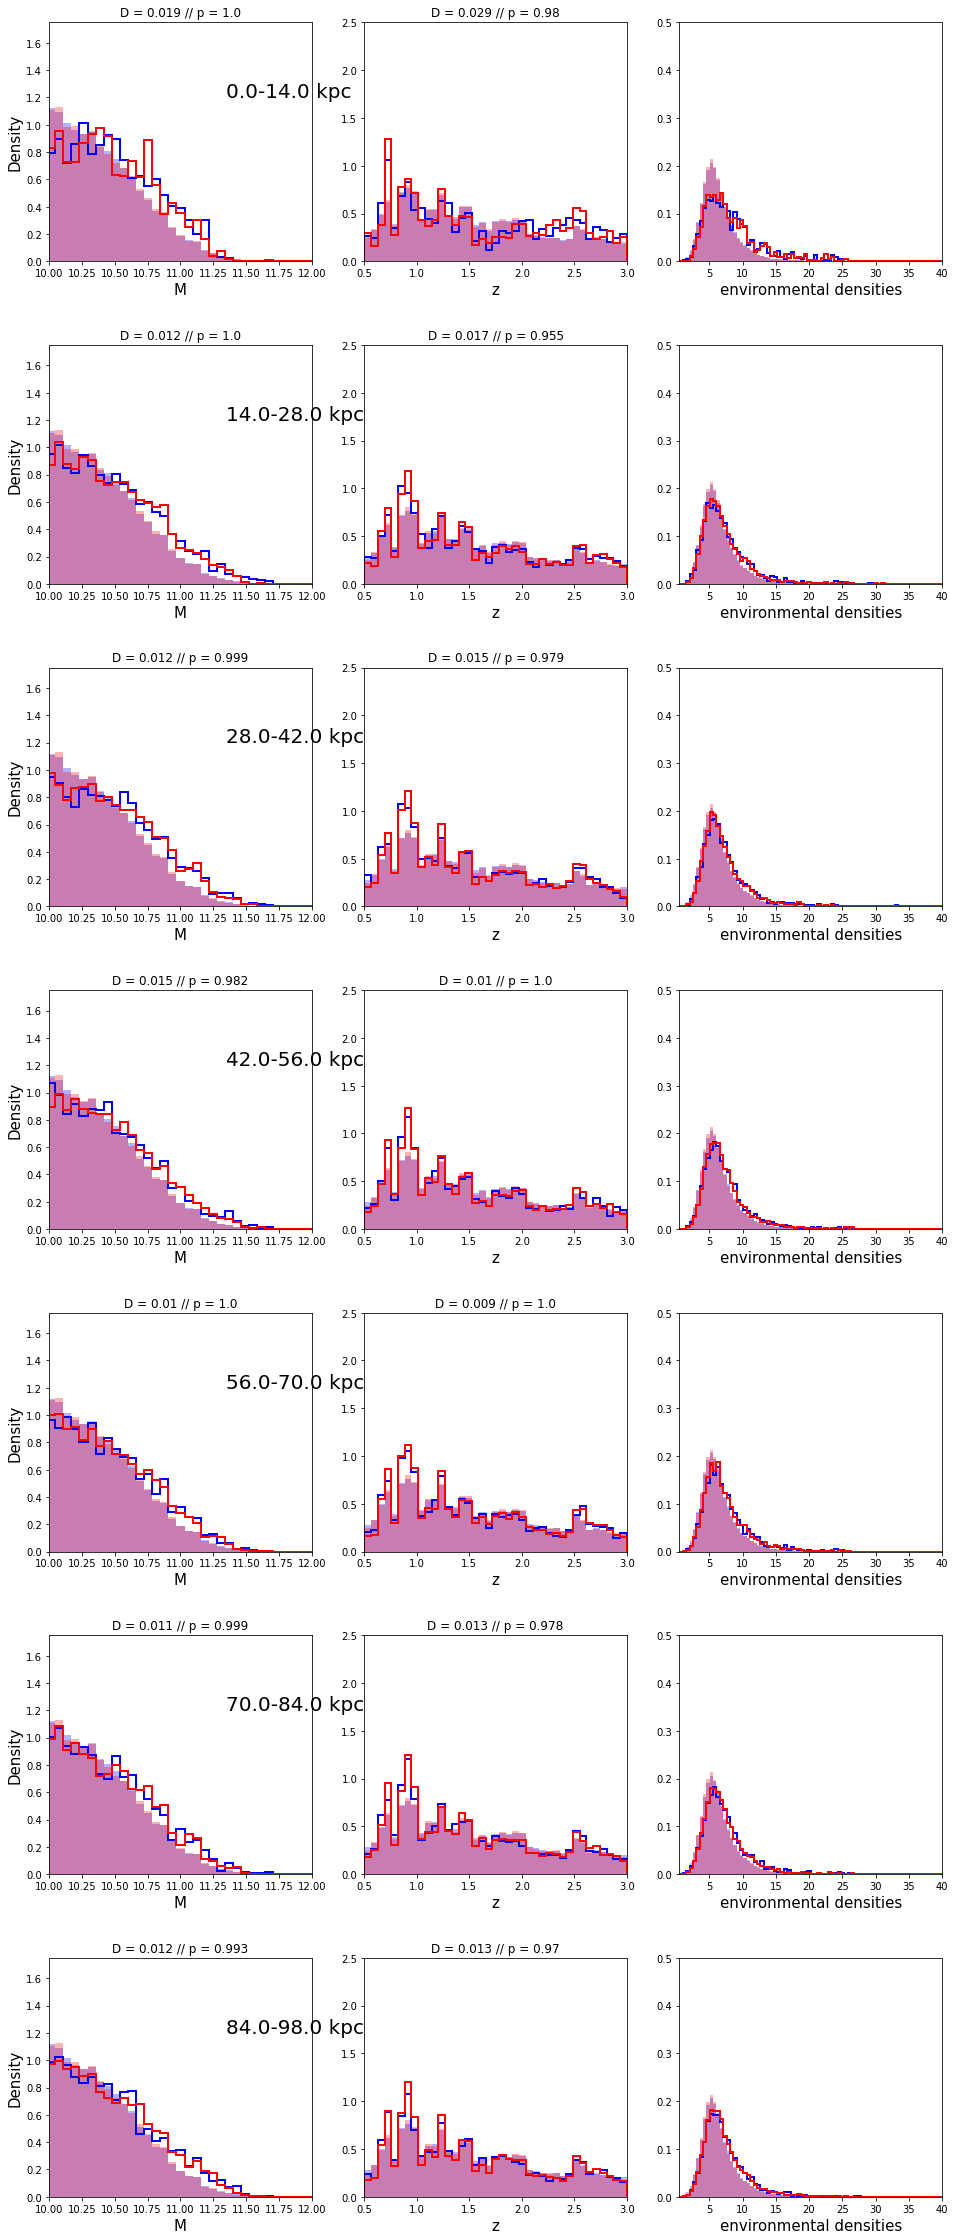

In [9]:
# let's look at the distributions for each key:
fig, ax = plt.subplots(nrows=n_bins, ncols=3, figsize=(16,40))
fig.subplots_adjust(hspace=0.35)
mbins = np.linspace(9.8,12.2,40)
zbins = np.linspace(0.5,3,40)
ebins = np.linspace(0,40,80)
if use_PdA == True:
    pprobs = p_wprobs
    iprobs = i_wprobs
elif use_PdA == False:
    pprobs = p_probs
    iprobs = i_probs
for i, key in enumerate(bin_dfs):
    # plot behind them the background distributions before and after weighting
    ax[i,0].hist(pmass_bin[key], bins=mbins, density=True, color='blue', alpha=0.3, label='pairs w/out weights')
    ax[i,0].hist(pmass_bin[key], bins=mbins, weights=pprobs[key], density=True, color='blue', histtype='step', lw=2, 
                 label='pairs w/ weights')
    ax[i,0].hist(imass_bin[key], bins=mbins, density=True, color='red', alpha=0.3, label='apples w/out weights')
    ax[i,0].hist(imass_bin[key], bins=mbins, weights=iprobs[key], density=True, histtype='step', color='red', lw=2,
                label='apples w/ weights')
    
    ax[i,1].hist(pz_bin[key], bins=zbins, density=True, color='blue', alpha=0.3)
    ax[i,1].hist(pz_bin[key], bins=zbins, weights=pprobs[key], color='blue', density=True, histtype='step', lw=2)
    ax[i,1].hist(iz_bin[key], bins=zbins, density=True, color='red', alpha=0.3)
    ax[i,1].hist(iz_bin[key], bins=zbins, weights=iprobs[key], density=True, histtype='step', color='red', lw=2)
    
    ax[i,2].hist(penv_bin[key], bins=ebins, density=True, color='blue', alpha=0.3)
    ax[i,2].hist(penv_bin[key], bins=ebins, weights=pprobs[key], color='blue', density=True, histtype='step', lw=2)
    ax[i,2].hist(ienv_bin[key], bins=ebins, density=True, color='red', alpha=0.3)
    ax[i,2].hist(ienv_bin[key], bins=ebins, weights=iprobs[key], density=True, histtype='step', color='red', lw=2)
    
    ax[i,0].text(11.35, 1.2, key+' kpc', fontsize=20)
    
    ax[i,0].set_xlabel('M', fontsize=15)
    ax[i,0].set_ylabel('Density', fontsize=15)
    ax[i,0].set_xlim(10,12)
    ax[i,0].set_ylim(0,1.75)
    
    ax[i,1].set_xlabel('z', fontsize=15)
    ax[i,1].set_xlim(0.5,3)
    ax[i,1].set_ylim(0,2.5)
    
    ax[i,2].set_xlabel('environmental densities', fontsize=15)
    ax[i,2].set_xlim(0.5,40)
    ax[i,2].set_ylim(0,0.5)
    
    # add KS informationL
    D_m, p_m = ks_weighted(pmass_bin[key], imass_bin[key], pprobs[key], iprobs[key])
    D_z, p_z = ks_weighted(pz_bin[key], iz_bin[key], pprobs[key], iprobs[key])
    ax[i,0].set_title('D = {0} // p = {1}'.format(round(D_m,3), round(p_m,3)))
    ax[i,1].set_title('D = {0} // p = {1}'.format(round(D_z,3), round(p_z,3)))
                      
    # if i == 0:
    #     ax[i,0].legend(fontsize=10, loc=4)
    
plt.show()

In [8]:
# # make the same distribution plots for the Donley IR subsamples:
# # let's look at the distributions for each key:
# fig, ax = plt.subplots(nrows=n_bins, ncols=2, figsize=(16,60))
# fig.subplots_adjust(hspace=0.35)
# mbins = np.linspace(9.5, 12.2, 40)
# zbins = np.linspace(0.5, 3, 40)
# if use_PdA == True:
#     pprobs = p_wprobs
#     iprobs = i_wprobs
# elif use_PdA == False:
#     pprobs = p_probs
#     iprobs = i_probs
    
# for i, key in enumerate(bin_dfs):
#     # grab the subset for just the IR AGN:
#     d_idx = np.where( pDo_bin[key] == 1 )
#     id_idx = np.where( iDo_bin[key] == 1 )
    
#     # plot behind them the background distributions before and after weighting
#     ax[i,0].hist(pmass_bin[key][d_idx], bins=mbins, density=True, color='blue', alpha=0.3, label='pairs w/out weights')
#     ax[i,0].hist(pmass_bin[key][d_idx], bins=mbins, weights=pprobs[key][d_idx], density=True, color='blue', histtype='step', lw=2, 
#                  label='pairs w/ weights')
#     ax[i,0].hist(imass_bin[key][id_idx], bins=mbins, density=True, color='red', alpha=0.3, label='apples w/out weights')
#     ax[i,0].hist(imass_bin[key][id_idx], bins=mbins, weights=iprobs[key][id_idx], density=True, histtype='step', color='red', lw=2,
#                 label='apples w/ weights')
    
#     ax[i,1].hist(pz_bin[key][d_idx], bins=zbins, density=True, color='blue', alpha=0.3)
#     a,b,c = ax[i,1].hist(pz_bin[key][d_idx], bins=zbins, weights=pprobs[key][d_idx], color='blue', density=True, histtype='step', lw=2)
#     ax[i,1].hist(iz_bin[key][id_idx], bins=zbins, density=True, color='red', alpha=0.3)
#     aa,bb,cc = ax[i,1].hist(iz_bin[key][id_idx], bins=zbins, weights=iprobs[key][id_idx], density=True, histtype='step', color='red', lw=2)
    
#     ax[i,0].text(11.25, 1.2, key+' kpc', fontsize=20)
    
#     ax[i,0].set_xlabel('M', fontsize=15)
#     ax[i,0].set_ylabel('Density', fontsize=15)
#     ax[i,0].set_xlim(9.5,12)
#     # ax[i,0].set_ylim(0,5)
    
#     ax[i,1].set_xlabel('z', fontsize=15)
#     ax[i,1].set_xlim(0.5,3)
#     # ax[i,1].set_ylim(0,2.5)
    
#     # add KS informationL
#     D_m, p_m = ks_weighted(pmass_bin[key][d_idx], imass_bin[key][d_idx], pprobs[key][d_idx], iprobs[key][d_idx])
#     D_z, p_z = ks_weighted(pz_bin[key][d_idx], iz_bin[key][d_idx], pprobs[key][d_idx], iprobs[key][d_idx])
#     ax[i,0].set_title('D = {0} // p = {1}'.format(round(D_m,3), round(p_m,3)))
#     ax[i,1].set_title('D = {0} // p = {1}'.format(round(D_z,3), round(p_z,3)))
                          
#     # if i == 0:
#     #     ax[i,0].legend(fontsize=10, loc=4)
    
# plt.show()

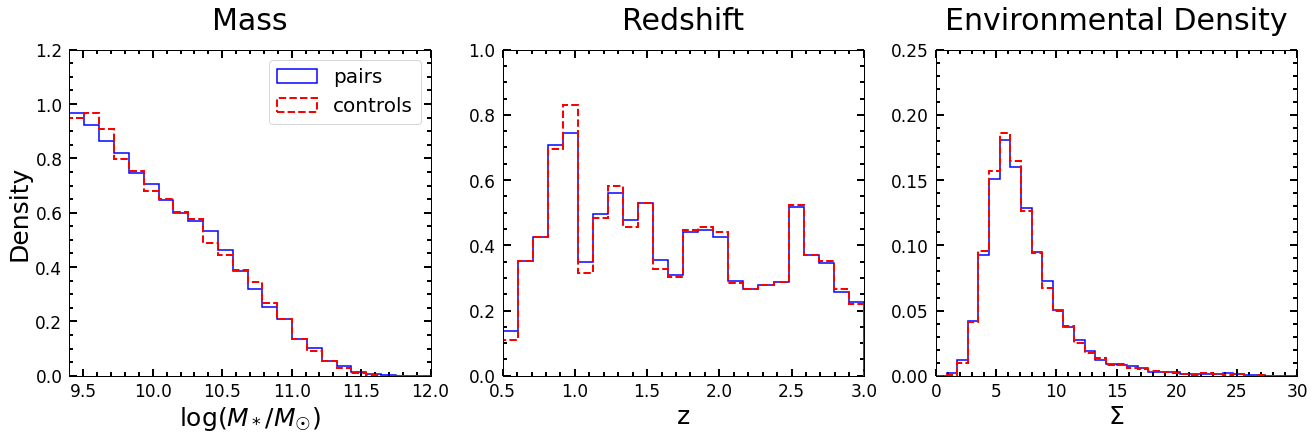

In [20]:
# all together now:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,6), sharey=False)
# fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(wspace=0.2)
zbins = np.linspace(0.5,3,25)
mbins = np.linspace(9.4,12.5,30)  # may actually have the wrong weights here
ebins = np.linspace(0,30,35)
pweights = np.concatenate((rdf['pair_prob'],rdf['pair_prob']))
iweights = np.concatenate((cdf['Cp'],cdf['Cp']))
# mass
# ax[0].hist(pmass, bins=mbins, density=True, color='blue', alpha=0.3, label='pairs w/out weights')
ax[0].hist(pmass, bins=mbins, weights=pweights, density=True, color='blue',
          histtype='step', lw=1.5, label='pairs')
# ax[0].hist(imass, bins=mbins, density=True, color='red', alpha=0.3, label='apples w/out weights')
ax[0].hist(imass, bins=mbins, weights=iweights, histtype='step', color='red', 
           density=True, lw=2, linestyle='--', label='controls')
ax[0].set_xlim(9.4,12)
ax[0].legend(fontsize=20)

# redshift
# ax[1].hist(pz, bins=zbins, density=True, color='blue', alpha=0.3)
ax[1].hist(pz, bins=zbins, weights=pweights, density=True, color='blue',
          histtype='step', lw=1.5)
# ax[1].hist(iz, bins=zbins, density=True, color='red', alpha=0.3)
ax[1].hist(iz, bins=zbins, weights=iweights, histtype='step', color='red', 
           density=True, lw=2, linestyle='--')
ax[1].set_xlim(0.5, 3)

# environment density:
# ax[2].hist(penv, bins=ebins, density=True, color='blue', alpha=0.3)
ax[2].hist(penv, bins=ebins, weights=pweights, density=True, color='blue',
          histtype='step', lw=1.5)
# ax[2].hist(ienv, bins=ebins, density=True, color='red', alpha=0.3)
ax[2].hist(ienv, bins=ebins, weights=iweights, histtype='step', color='red', 
           density=True, lw=2, linestyle='--')
ax[2].set_xlim(0, 30)


ax[0].set_ylabel('Density', fontsize=25)
ax[0].set_xlabel('log($M_*/M_☉$)', fontsize=25)
# ax[2].set_ylabel('Density', fontsize=25)
ax[2].set_xlabel('$\Sigma$', fontsize=25)
# ax[1].set_ylabel('Density', fontsize=25)
ax[1].set_xlabel('z', fontsize=25)

ax[0].set_ylim(0,1.2)
ax[0].set_title('Mass', fontsize=30, pad=20)
ax[0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

ax[1].set_ylim(0,1)
ax[1].set_title('Redshift', fontsize=30, pad=20)
ax[1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

ax[2].set_ylim(0,0.25)
ax[2].set_title('Environmental Density', fontsize=30, pad=20)
ax[2].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# do the KS-test:
# D_m, p_m = ks_weighted(pmass, imass, pweights, iweights)
# D_z, p_z = ks_weighted(pz, iz, pweights, iweights)
# ax[0,0].set_title('D = {0} // p = {1}'.format(round(D_m,3), round(p_m,3)))
# ax[1,0].set_title('D = {0} // p = {1}'.format(round(D_z,3), round(p_z,3)))

# # plot distributions of weights:
# wei_bins = np.logspace(-21,0, 100)
# ax[1,1].hist(pweights, bins=wei_bins, histtype='step', lw=2, color='blue', density=False)
# ax[1,1].hist(iweights, bins=wei_bins, histtype='step', lw=2, color='red', density=False)
# ax[1,1].set_xscale('log')
# ax[1,1].set_xlabel('Pair Prob', fontsize=20)
# ax[1,1].set_ylabel('Counts', fontsize=20)

plt.savefig('/data/c1029594/CANDELS_AGN_merger_code/figs/control_match.png', bbox_inches='tight')

plt.show()

In [11]:
# ### ~~~ ALSO WANT TO SEE DISTRIBUTIONS OF KPC SEPARATION, TO CONFIRM APPLES ARE ISOS ~~~ ###
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
# sep_bins=np.linspace(0,1500,1501)
# ax.hist(rdf['arc_sep'], bins=sep_bins, density=True, color='blue')
# ax.hist(cdf['arc_sep'], bins=sep_bins, density=True, color='red')
# plt.show()
# ### WE KNOW THERE IS THIS INTERPOLATION BUG FOR SMALL NEGATIVE VALUES, SHOULD PROBABLY JUST CLIP THESE TO ZERO ###
# ### MAY ALSO REQUIRE THE APPLES TO HAVE A PROB > 0 ###

In [22]:
# # run some ks tests: 
# ### ~~~ WILL WANT TO DOUBLE CHECK THE LOGIC OF THE WEIGHTED KS TEST ~~~ ###
# ### ~~~ HOPEFULLY THE ADDITION OF COSMOS WILL REASONABLY BULT OF THE STATISTICS ~~~ ###
# for key in bin_dfs: # hmm...
#     D_m, p_m = ks_weighted(pmass_bin[key], imass_bin[key], pprobs[key], iprobs[key])
#     D_z, p_z = ks_weighted(pz_bin[key], iz_bin[key], pprobs[key], iprobs[key])
    
#     D_m, p_m = ks_weighted(pmass_bin[key], imass_bin[key], np.array([1]*len(pprobs[key])), np.array([1]*len(iprobs[key])))
#     D_z, p_z = ks_weighted(pz_bin[key], iz_bin[key], np.array([1]*len(pprobs[key])), np.array([1]*len(iprobs[key])))
    
#     print(key, '-- MASS -->', D_m, p_m)
#     print(key, '-- z -->', D_z, p_z)

In [18]:
# collect count numbers in a df <- FORGET ABOUT ISOLATED GALAXIES FOR NOW
all_pairs_df = pd.DataFrame.from_dict([tot_pair])
all_iso_df = pd.DataFrame.from_dict([tot_iso])
pXAGN_df = pd.DataFrame.from_dict([pXAGN_count])
iXAGN_df = pd.DataFrame.from_dict([iXAGN_count])
pIRAGN_df = pd.DataFrame.from_dict([pIRAGN_count])
iIRAGN_df = pd.DataFrame.from_dict([iIRAGN_count])
# pStAGN_df = pd.DataFrame.from_dict([pStAGN_count])
# iStAGN_df = pd.DataFrame.from_dict([iStAGN_count])

df = pd.concat([all_pairs_df, pXAGN_df, pIRAGN_df,
               all_iso_df, iXAGN_df, iIRAGN_df], ignore_index = True, axis=0)
# df = df.rename(index={0: 'Paired Gals', 1: 'Paired X-ray AGN', 2: 'Paired Dale AGN', 
#                       3: 'Paired Donley AGN', 4:'Paired Stern AGN'})
df = df.rename(index={0:'Paired Gals', 1:'X-ray AGN', 2:'IR AGN',
                     3:'Apple Gals', 4:'Apple X-ray AGN', 5:'Apple IR AGN'})
df

,0.0-20.0,20.0-40.0,40.0-60.0,60.0-80.0,80.0-100.0
Paired Gals,76.716994,106.884033,102.693856,118.965743,133.469350
X-ray AGN,7.752000,12.325802,15.427543,17.359830,17.021711
IR AGN,3.021145,2.548415,4.625355,5.574078,2.532292
Apple Gals,230.046641,319.959201,308.275062,356.895459,401.770082
Apple X-ray AGN,30.836336,38.988925,28.308374,38.880106,35.285188
Apple IR AGN,6.195131,6.662447,4.079615,7.267964,7.488088


In [89]:
def binomial_err(c, k, n):
    p_lower = dist.beta.ppf((1-c)/2., k+1, n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2., k+1, n-k+1)
    return p_lower, p_upper

In [90]:
# calculate errors correctly:
# get errors as numpy arrays
pXAGN_err0 = np.array([pXAGN_err[key] for key in pXAGN_err])
pDoAGN_err0 = np.array([pDoAGN_err[key] for key in pDoAGN_err])
poDoAGN_err0 = np.array([poDoAGN_err[key] for key in poDoAGN_err])
pStAGN_err0 = np.array([pStAGN_err[key] for key in pStAGN_err])
p_err0 = np.array([p_err[key] for key in p_err])
iXAGN_err0 = np.array([iXAGN_err[key] for key in iXAGN_err])
iDoAGN_err0 = np.array([iDoAGN_err[key] for key in iDoAGN_err])
ioDoAGN_err0 = np.array([ioDoAGN_err[key] for key in ioDoAGN_err])
iStAGN_err0 = np.array([iStAGN_err[key] for key in iStAGN_err])
i_err0 = np.array([i_err[key] for key in i_err])

pXAGN_count0 = np.array([pXAGN_count[key] for key in pXAGN_count])
pDoAGN_count0 = np.array([pDoAGN_count[key] for key in pDoAGN_count])
poDoAGN_count0 = np.array([poDoAGN_count[key] for key in poDoAGN_count])
pStAGN_count0 = np.array([pStAGN_count[key] for key in pStAGN_count])
iXAGN_count0 = np.array([iXAGN_count[key] for key in iXAGN_count])
iDoAGN_count0 = np.array([iDoAGN_count[key] for key in iDoAGN_count])
ioDoAGN_count0 = np.array([ioDoAGN_count[key] for key in ioDoAGN_count])
iStAGN_count0 = np.array([iStAGN_count[key] for key in iStAGN_count])

pXfrac_err = pXAGN_fracs * np.sqrt( (pXAGN_err0/pXAGN_count0)**2 + (p_err0/tot_pairs)**2 )
pX_uerr = pXAGN_fracs + pXfrac_err
pX_lerr =  pXAGN_fracs - pXfrac_err
pDofrac_err = pDoAGN_fracs * np.sqrt( (pDoAGN_err0/pDoAGN_count0)**2 + (p_err0/tot_pairs)**2 )
pDo_uerr = pDoAGN_fracs + pDofrac_err
pDo_lerr =  pDoAGN_fracs - pDofrac_err
pStfrac_err = pStAGN_fracs * np.sqrt( (pStAGN_err0/pStAGN_count0)**2 + (p_err0/tot_pairs)**2 )
pSt_uerr = pStAGN_fracs + pStfrac_err
pSt_lerr =  pStAGN_fracs - pStfrac_err

iXfrac_err = iXAGN_fracs * np.sqrt( (iXAGN_err0/iXAGN_count0)**2 + (i_err0/tot_isos)**2 )
iX_uerr = iXAGN_fracs + iXfrac_err
iX_lerr =  iXAGN_fracs - iXfrac_err
iDofrac_err = iDoAGN_fracs * np.sqrt( (iDoAGN_err0/iDoAGN_count0)**2 + (i_err0/tot_isos)**2 )
iDo_uerr = iDoAGN_fracs + iDofrac_err
iDo_lerr =  iDoAGN_fracs - iDofrac_err
iStfrac_err = iStAGN_fracs * np.sqrt( (iStAGN_err0/iStAGN_count0)**2 + (i_err0/tot_isos)**2 )
iSt_uerr = iStAGN_fracs + iStfrac_err
iSt_lerr =  iStAGN_fracs - iStfrac_err

# for obscured/unabscured:
p_obsc_frac = poDoAGN_count0 / pXAGN_count0
p_obsc_frac_err = p_obsc_frac * np.sqrt( (poDoAGN_err0/poDoAGN_count0)**2 + (pXAGN_err0/pXAGN_count0)**2 )
i_obsc_frac = ioDoAGN_count0 / iXAGN_count0
i_obsc_frac_err = i_obsc_frac * np.sqrt( (ioDoAGN_err0/ioDoAGN_count0)**2 + (iXAGN_err0/iXAGN_count0)**2 )

In [91]:
p_obsc_frac, i_obsc_frac, p_obsc_frac_err, i_obsc_frac_err

(array([0.27017035, 0.16676521, 0.13993289, 0.12908065, 0.13191738]),
 array([0.11066184, 0.11016338, 0.12034404, 0.13725442, 0.15015111]),
 array([0.05595589, 0.03232395, 0.02259076, 0.02253764, 0.01944891]),
 array([0.02155343, 0.01173208, 0.01136966, 0.01269717, 0.01391337]))

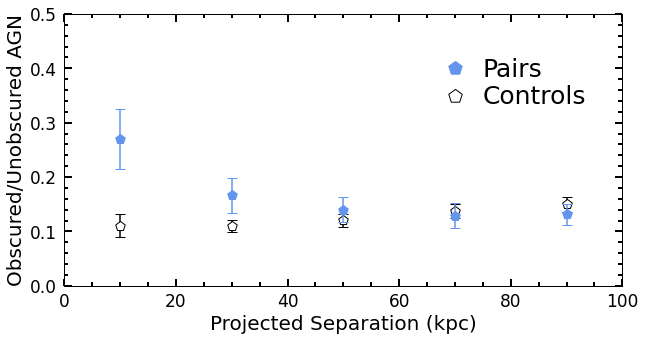

In [93]:
# obscured / unobscured fraction plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.scatter(kpc_meds, p_obsc_frac, s=100, color='cornflowerblue', marker='p', zorder=2, label='Pairs')
ax.errorbar(kpc_meds, p_obsc_frac, yerr=(p_obsc_frac_err), linestyle='None', 
            color='cornflowerblue', capsize=5, zorder=2)

ax.errorbar(kpc_meds, i_obsc_frac, yerr=(i_obsc_frac_err), linestyle='None', 
            color='black', capsize=5, zorder=1)
ax.scatter(kpc_meds, i_obsc_frac, s=100, edgecolor='black', marker='p', facecolor='white', zorder=1, label='Controls')

ax.scatter(70, 0.40, s=200, marker='p', color='cornflowerblue')
ax.scatter(70, 0.35, s=200, marker='p', color='white', edgecolor='black')
ax.text(75, .385, 'Pairs', fontsize=25)
ax.text(75, .335, 'Controls', fontsize=25)

ax.set_ylim(0,0.5)
ax.set_xlim(0,100)
# ax.legend(fontsize=25)

ax.set_xlabel('Projected Separation (kpc)', fontsize=20)
ax.set_ylabel('Obscured/Unobscured AGN', fontsize=20)
ax.tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# plt.savefig('/data/c1029594/CANDELS_AGN_merger_code/figs/obscfrac.png', bbox_inches='tight')

plt.show()

In [54]:
# # plot IR full detection fraction
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# ax.scatter(kpc_meds, pdet_fracs, s=200, color='blue', zorder=2)
# ax.errorbar(kpc_meds, pdet_fracs, yerr=(pdet_frac_err), xerr=vwidth/2, linestyle='None', 
#             color='blue', capsize=5, zorder=2)

# ax.scatter(kpc_meds, idet_fracs, s=200, edgecolor='cornflowerblue', facecolor='None', zorder=1)
# ax.errorbar(kpc_meds, idet_fracs, yerr=(idet_frac_err), xerr=vwidth/2, linestyle='None', 
#             color='cornflowerblue', capsize=5, zorder=1)

# ax.set_ylim(0,1)
# ax.set_xlim(0,120)

# ax.set_xlabel('projected separation (kpc)', fontsize=15)
# ax.set_ylabel('IRAC full detection fraction', fontsize=15)

# plt.show() # note that this is with weights

# detaction fractions for COSMOS are much lower, but there seems to be no trend with proj sep (aside from with mass)
# what is the deal with COSMOS? low IR AGN fractions in lowest bin, but no quality difference in the detections...
# --> or at least there's no difference in their IRAC quality...
# what is driving the suppression of IR AGN in close separations that isn't seen in any other bin...
# Could be:
# ---> the PdA for COSMOS behaves differently for whatever reason (fit code for use_PdA == False: CANDELS+COSMOS consistent)
# ---> COSMOS spec-zs behave differently (check the just phot-z COSMOS: RUNNING)
# ---> some COSMOS data loading error (look in topcat: not a spatial issue with the data, mix up fluxes maybe?)
# ---> take a look at the first bin distributions (only noticeable difference is CANDELS has more high-z pairs)
# ---> try making a subset of just Donley AGN that are counted in each bin?
# ---> could it be the SPLASH IR fluxes are poor? (try splitting IRAC ch1 vs SPLASH ch1)
# ---> IRAC and SPLASH mostly consistent in flux, vary different in flux err (at least in first two channels: look at FARMER)
# ---> seems that IRAC flux errors are much less at least in CH1+2...
# ---> should use FARMER + EAZY for consistency, as this (like the CANDELS PDFs) ised all IRAC channels.
# -------> I believe this is the cause of the COSMOS inconsistencies (EAZY was used. by Wyuts)



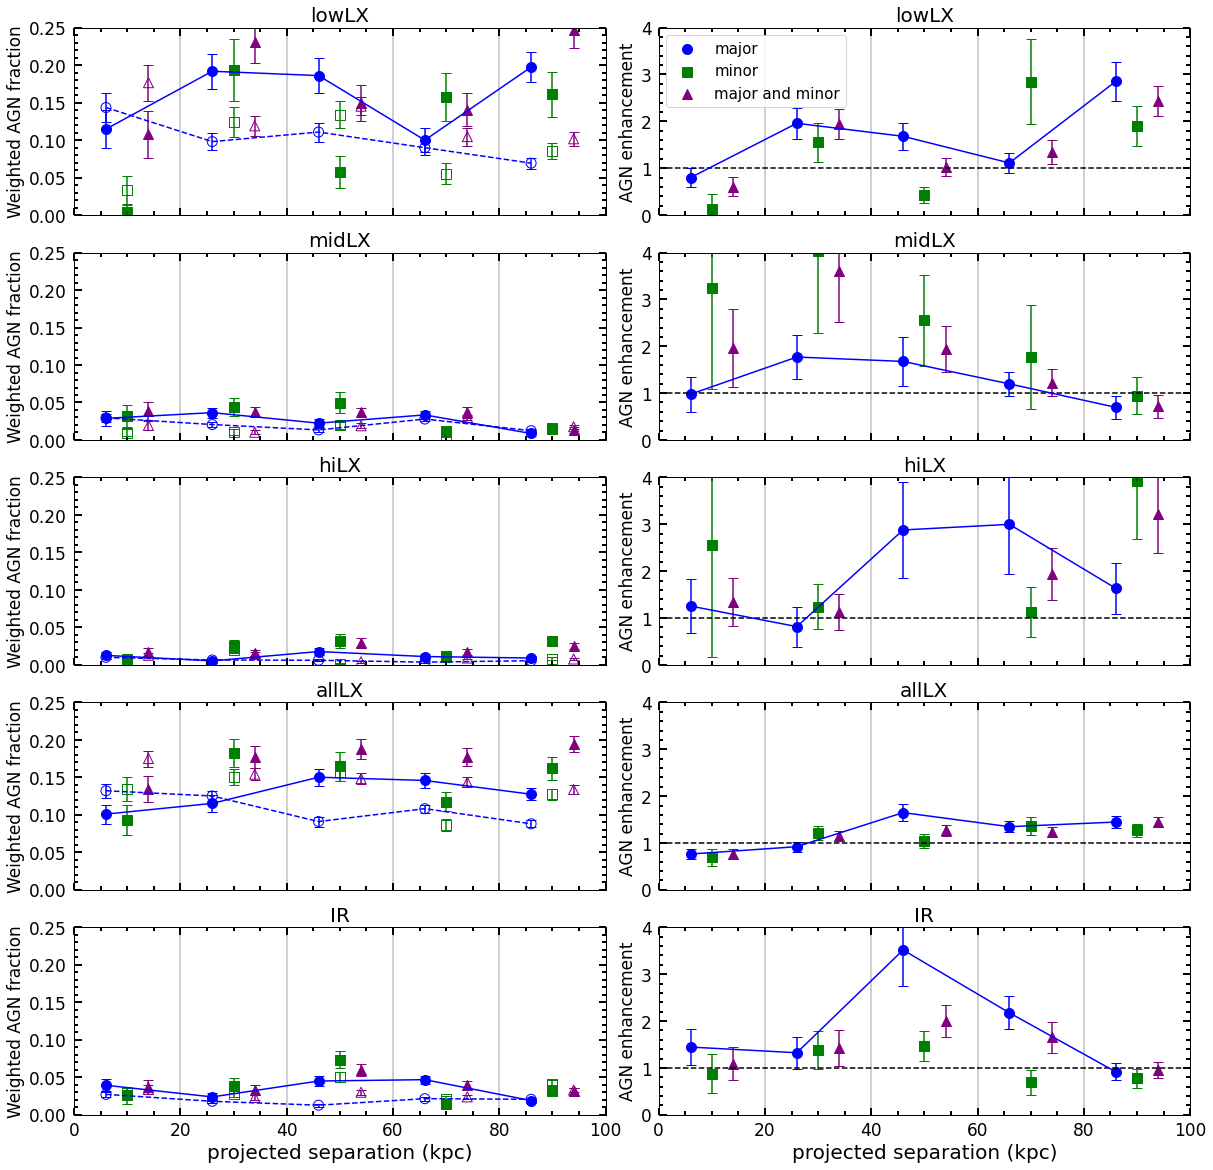

In [19]:
# plot AGN fractions / enhancement master plot:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20,20), sharex=True) #sharey=True)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.2)

AGNs = ['lowLX','midLX','hiLX','allLX','IR']
kpc_meds = np.array(kpc_meds)
kpc_centers = [((kpc_meds[i] + kpc_meds[i+1])/2) for i in range(0, len(kpc_meds)-1)]

# for loop for mass samples
for i, AGN in enumerate(AGNs):
    maj_frac = np.array([major[AGN+'_frac'][col] for col in major[AGN+'_frac']])
    maj_se = np.array([major[AGN+'_se'][col] for col in major[AGN+'_se']])
    imaj_frac = np.array([major['i'+AGN+'_frac'][col] for col in major['i'+AGN+'_frac']])
    imaj_se = np.array([major['i'+AGN+'_se'][col] for col in major['i'+AGN+'_se']])
    min_frac = np.array([minor[AGN+'_frac'][col] for col in minor[AGN+'_frac']])
    min_se = np.array([minor[AGN+'_se'][col] for col in minor[AGN+'_se']])
    imin_frac = np.array([minor['i'+AGN+'_frac'][col] for col in minor['i'+AGN+'_frac']])
    imin_se = np.array([minor['i'+AGN+'_se'][col] for col in minor['i'+AGN+'_se']])
    majmin_frac = np.array([major_minor[AGN+'_frac'][col] for col in major_minor[AGN+'_frac']])
    majmin_se = np.array([major_minor[AGN+'_se'][col] for col in major_minor[AGN+'_se']])
    imajmin_frac = np.array([major_minor['i'+AGN+'_frac'][col] for col in major_minor['i'+AGN+'_frac']])
    imajmin_se = np.array([major_minor['i'+AGN+'_se'][col] for col in major_minor['i'+AGN+'_se']])
    
    ax[i,0].scatter(kpc_meds-4, maj_frac, s=100, color='blue')
    ax[i,0].errorbar(kpc_meds-4, maj_frac, yerr=maj_se, color='blue', capsize=5)
    ax[i,0].scatter(kpc_meds-4, imaj_frac, s=100, edgecolor='blue', facecolor='none')
    ax[i,0].errorbar(kpc_meds-4, imaj_frac, yerr=imaj_se, color='blue', capsize=5, linestyle='--')
    ax[i,0].scatter(kpc_meds, min_frac, s=100, color='green', marker='s')
    ax[i,0].errorbar(kpc_meds, min_frac, yerr=min_se, color='green', capsize=5, linestyle='none')
    ax[i,0].scatter(kpc_meds, imin_frac, s=100, edgecolor='green', facecolor='none', marker='s')
    ax[i,0].errorbar(kpc_meds, imin_frac, yerr=imin_se, color='green', capsize=5, linestyle='none')
    ax[i,0].scatter(kpc_meds+4, majmin_frac, s=100, color='purple', marker='^')
    ax[i,0].errorbar(kpc_meds+4, majmin_frac, yerr=majmin_se, color='purple', capsize=5, linestyle='none')
    ax[i,0].scatter(kpc_meds+4, imajmin_frac, s=100, edgecolor='purple', facecolor='none', marker='^')
    ax[i,0].errorbar(kpc_meds+4, imajmin_frac, yerr=imajmin_se, color='purple', capsize=5, linestyle='none')
    
    ax[i,0].set_title(AGN, fontsize=20)
    ax[i,0].set_xlim(0,100)
    ax[i,0].set_ylim(0,0.25)
    # ax[i,0].set_xlabel('projected separation (kpc)')
    ax[i,0].set_ylabel('Weighted AGN fraction', fontsize=17)
    ax[i,0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
    ax[i,0].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i,0].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i,0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
    maj_enh = maj_frac / imaj_frac
    min_enh = min_frac / imin_frac
    majmin_enh = majmin_frac / imajmin_frac
    # propogate errors linearly
    maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
    min_enh_se = min_enh * np.sqrt( (min_se/min_frac)**2 + (imin_se/imin_frac)**2 )
    majmin_enh_se = majmin_enh * np.sqrt( (majmin_se/majmin_frac)**2 + (imajmin_se/imajmin_frac)**2 )
    
    ax[i,1].scatter(kpc_meds-4, maj_enh, s=100, color='blue', label='major')
    ax[i,1].errorbar(kpc_meds-4, maj_enh, yerr=maj_enh_se, color='blue', capsize=5)
    ax[i,1].scatter(kpc_meds, min_enh, s=100, color='green', marker='s', label='minor')
    ax[i,1].errorbar(kpc_meds, min_enh, yerr=min_enh_se, color='green', capsize=5, linestyle='none')
    ax[i,1].scatter(kpc_meds+4, majmin_enh, s=100, color='purple', marker='^', label='major and minor')
    ax[i,1].errorbar(kpc_meds+4, majmin_enh, yerr=majmin_enh_se, color='purple', capsize=5, linestyle='none')
    ax[i,1].plot([0,100],[1,1], color='black', linestyle='--')
    
    ax[i,1].set_title(AGN, fontsize=20)
    ax[i,1].set_xlim(0,100)
    ax[i,1].set_ylim(0,4)
    # ax[i,1].set_xlabel('projected separation (kpc)')
    ax[i,1].set_ylabel('AGN enhancement', fontsize=17)
    ax[i,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
    ax[i,1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i,1].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
    for kpc in kpc_meds:
        ax[i,0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05)
        ax[i,1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05)
        
        
ax[4,0].set_xlabel('projected separation (kpc)', fontsize=20)
ax[4,1].set_xlabel('projected separation (kpc)', fontsize=20)

ax[0,1].legend(loc=2, fontsize=15)
        
ax[0,0].set_xlim(0,100)


# X-ray -> three tiers
# ax[0].scatter(kpc_meds, pXAGN_fracs, color='blue')
# ax[0].errorbar(kpc_meds, pXAGN_fracs, yerr=(pXfrac_err,pXfrac_err), linestyle="None", capsize=10, color='blue')
# ax[0].scatter(kpc_meds, iXAGN_fracs, s=50, facecolor='none', edgecolor='red')
# ax[0].errorbar(kpc_meds, iXAGN_fracs, yerr=(iXfrac_err,iXfrac_err), linestyle="None", capsize=10, color='red')
# ax[0].set_ylim(0, 0.199)
# ax[0].set_ylabel('AGN fraction', fontsize=15)
# # ax[0].set_xlabel('projected separation (kpc)', fontsize=15)
# ax[0].text(2,0.17,'X-ray AGN', fontsize=25)

# IR
# ax[1].scatter(kpc_meds, pDoAGN_fracs, color='blue')
# ax[1].errorbar(kpc_meds, pDoAGN_fracs, yerr=(pDofrac_err,pDofrac_err), linestyle="None", capsize=10, color='blue')
# ax[1].scatter(kpc_meds, iDoAGN_fracs, s=50, facecolor='none', edgecolor='red')
# ax[1].errorbar(kpc_meds, iDoAGN_fracs, yerr=(iDofrac_err,iDofrac_err), linestyle="None", capsize=10, color='red')
# ax[1].set_ylim(0, 0.199)
# # ax[1].set_xlabel('projected separation (kpc)', fontsize=15)
# ax[1].set_ylabel('AGN fraction', fontsize=15)
# ax[1].text(2,0.17,'Donley AGN', fontsize=25)


# ax[0].set_xticks(np.arange(0,150,20))
# ax[0].set_xticklabels(np.arange(0,150,20),fontsize=15)
# ax[0].set_yticks(np.arange(0,0.12,0.02))
# ax[0].set_yticklabels(np.arange(0,0.12,0.02),fontsize=15)


# ax[1].set_xticks(np.arange(0,150,20))
# ax[1].set_xticklabels(np.arange(0,150,20),fontsize=15)

# plt.savefig(PATH+'AP_PP_150kpc.png')
plt.show()

In [20]:
major['allLX_count'], major['iallLX_count']

({'0.0-20.0': 7.752000289725254,
  '20.0-40.0': 12.32580245935162,
  '40.0-60.0': 15.42754332114943,
  '60.0-80.0': 17.359830078303553,
  '80.0-100.0': 17.02171099766666},
 {'0.0-20.0': 30.301930956296545,
  '20.0-40.0': 39.92169552909256,
  '40.0-60.0': 27.949878641159003,
  '60.0-80.0': 38.668634356082364,
  '80.0-100.0': 35.31119869556823})

In [85]:
# calculate AGN enhancement and propogate error once more:
Enh_X = pXAGN_fracs / iXAGN_fracs
Enh_X_err = Enh_X * np.sqrt( (pXfrac_err/pXAGN_fracs)**2 + (iXfrac_err/iXAGN_fracs)**2 )
Enh_DoIR = pDoAGN_fracs / iDoAGN_fracs
Enh_DoIR_err = Enh_DoIR * np.sqrt( (pDofrac_err/pDoAGN_fracs)**2 + (iDofrac_err/iDoAGN_fracs)**2 )
Enh_StIR = pStAGN_fracs / iStAGN_fracs
Enh_StIR_err = Enh_StIR * np.sqrt( (pStfrac_err/pStAGN_fracs)**2 + (iStfrac_err/iStAGN_fracs)**2 )

# p_obsc_frac, i_obsc_frac, p_obsc_frac_err, i_obsc_frac_err
Enh_oDoIR = p_obsc_frac / i_obsc_frac
Enh_oDoIR_err = Enh_oDoIR * np.sqrt( (p_obsc_frac_err/p_obsc_frac)**2 + (i_obsc_frac_err/i_obsc_frac)**2 )

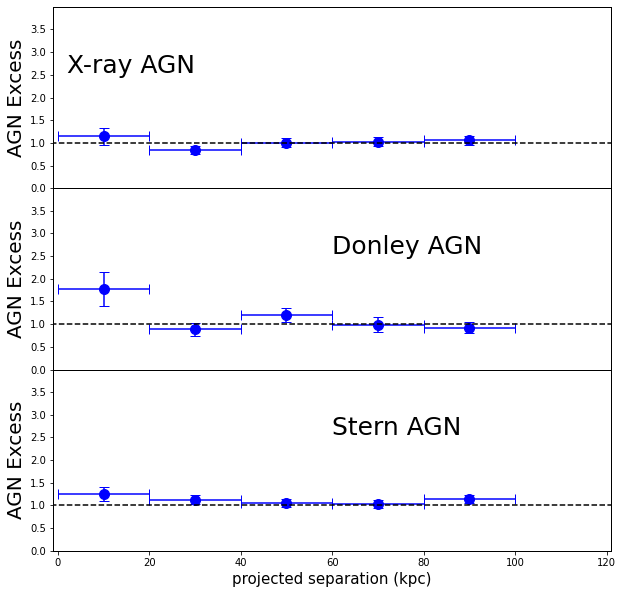

In [86]:
# AGN enhancement plot:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True) #sharey=True)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0)
# X-ray
ax[0].scatter(kpc_meds, Enh_X, s=100, color='blue')
ax[0].errorbar(kpc_meds, Enh_X, yerr=(Enh_X_err,Enh_X_err), xerr=vwidth/2, linestyle="None", capsize=5, color='blue')
ax[0].plot([-5,200], [1,1], linestyle='--', color='black')
ax[0].set_ylim(0, 3.99)
ax[0].set_xlim(-1,121)
ax[0].set_ylabel('AGN Excess', fontsize=20)
# ax[0].set_xlabel('projected separation (kpc)', fontsize=15)
ax[0].text(2,2.55,'X-ray AGN', fontsize=25)

# Donley
ax[1].scatter(kpc_meds, Enh_DoIR, s=100, color='blue')
ax[1].errorbar(kpc_meds, Enh_DoIR, yerr=(Enh_DoIR_err,Enh_DoIR_err), xerr=vwidth/2, linestyle="None", capsize=5, color='blue')
ax[1].plot([-5,200], [1,1], linestyle='--', color='black')
ax[1].set_ylim(0, 3.99)
# ax[1].set_xlabel('projected separation (kpc)', fontsize=15)
ax[1].set_ylabel('AGN Excess', fontsize=20)
ax[1].text(60,2.55,'Donley AGN', fontsize=25)

# Stern
ax[2].scatter(kpc_meds, Enh_StIR, s=100, color='blue')
ax[2].errorbar(kpc_meds, Enh_StIR, yerr=(Enh_StIR_err,Enh_StIR_err), xerr=vwidth/2, linestyle="None", capsize=5, color='blue')
ax[2].plot([-5,200], [1,1], linestyle='--', color='black')
ax[2].set_ylim(0, 3.99)
ax[2].set_xlabel('projected separation (kpc)', fontsize=15)
ax[2].set_ylabel('AGN Excess', fontsize=20)
ax[2].text(60,2.55, 'Stern AGN', fontsize=25)

plt.show()

# loss of IR Don AGN likely due to contamination in control sample, work in a modest cut of 0.5 to weed out spectroscopic pairs

In [70]:
# Enh_X1000 = Enh_X
# Enh_X_err1000 = Enh_X_err
# Enh_DoIR1000 = Enh_DoIR
# Enh_DoIR_err1000 = Enh_DoIR_err
# Enh_DoIR1000 = Enh_oDoIR
# Enh_DoIR_err1000 = Enh_oDoIR_err

Enh_X500 = Enh_X
Enh_X_err500 = Enh_X_err
Enh_DoIR500 = Enh_DoIR
Enh_DoIR_err500 = Enh_DoIR_err

# data points for Ellison+13:
Ell13 = np.array([
    5.0666666666666735, 2.556420233463035,
    15.09333333333334, 1.9571984435797662,
    25.119999999999997, 1.6536964980544746,
    35.04, 1.459143968871595,
    44.959999999999994, 1.3112840466926068,
    54.986666666666665, 1.2879377431906613,
    65.01333333333332, 1.155642023346303,
    75.03999999999999, 1.2490272373540856])
Ell13err = np.array([
    5.0666666666666735, 2.8210116731517507,
    15.09333333333334, 2.11284046692607,
    25.119999999999997, 1.7937743190661477,
    35.04, 1.591439688715953,
    44.959999999999994, 1.4357976653696496,
    54.986666666666665, 1.4124513618677041,
    65.01333333333332, 1.2568093385214008,
    75.03999999999999, 1.3657587548638133])
Ell13_enh = Ell13[1::2]
Ell13_x = Ell13[::2]
Ell13_enherr = Ell13err[1::2] - Ell13_enh

# Satyapal+14
Sat14 = np.array([
    5.0381679389312986, 3.7539936102236453,
    15.012722646310436, 3.3706070287539944,
    24.98727735368957, 2.6517571884984044,
    34.961832061068705, 1.789137380191697,
    45.038167938931295, 1.6932907348242843,
    55.012722646310436, 1.4057507987220461,
    64.98727735368958, 1.0223642172523988,
    74.9618320610687, 1.0223642172523988])
Sat14err = np.array([
    5.0381679389312986, 4.616613418530353,
    15.012722646310436, 3.945686900958467,
    25.089058524173026, 2.1725239616613443,
    35.06361323155216, 2.220447284345049,
    45.038167938931295, 1.3099041533546334,
    55.012722646310436, 1.7412140575079889,
    64.98727735368958, 1.2619808306709288,
    74.9618320610687, 1.3099041533546334])
Sat14_enh = Sat14[1::2]
Sat14_x = Sat14[::2]
Sat14_enherr = np.abs(Sat14err[1::2] - Sat14_enh)

# Shah data:
Sha20 = np.array([14.101382488479267, 0.9266055045871555,
    37.88018433179723, 1.0642201834862384,
    63.133640552995395, 1.1834862385321099,
    88.38709677419354, 0.8623853211009171,
    112.53456221198155, 0.9357798165137607,
    136.68202764976957, 1.0275229357798166])
Sha20errU = np.array([14.101382488479267, 1.1467889908256872,
    37.88018433179723, 1.2935779816513757,
    63.133640552995395, 1.4862385321100917,
    88.38709677419354, 1.045871559633027,
    112.53456221198155, 1.1559633027522933,
    136.68202764976957, 1.2752293577981648])
Sha20errL = np.array([13.888888888888893, 0.7798165137614674,
    37.592592592592595, 0.8807339449541276,
    63.14814814814815, 0.9633027522935782,
    88.5185185185185, 0.7247706422018352,
    112.77777777777779, 0.7706422018348622,
    137.037037037037, 0.853211009174311])
Sha20_enh = Sha20[1::2]
Sha20_x = Sha20[::2]
Sha20_enherrU = np.abs(Sha20errU[1::2] - Sha20_enh)
Sha20_enherrL = np.abs(Sha20errL[1::2] - Sha20_enh)

ShaIR20 = np.array([13.980582524271842, 0.9767441860465098,
    37.66990291262136, 1.87596899224806,
    63.10679611650485, 1.2248062015503862,
    88.54368932038835, 0.6976744186046488,
    112.81553398058254, 0.4586046511627879,
    136.89320388349518, 0.759689922480618])
ShaIR20errU = np.array([13.980582524271842, 1.5348837209302317,
    37.66990291262136, 3.147286821705425,
    63.10679611650485, 2.155038759689921,
    88.54368932038835, 1.2558139534883708,
    112.62135922330098, 0.8837209302325562,
    137.0873786407767, 1.441860465116278])
ShaIR20errL = np.array([13.980582524271842, 0.6356589147286797,
    37.66990291262136, 1.2248062015503862,
    63.10679611650485, 0.7906976744186025,
    88.54368932038835, 0.4186046511627879,
    112.81553398058254, 0.32558139534883423,
    136.89320388349518, 0.44961240310077244])
ShaIR20_enh = ShaIR20[1::2]
ShaIR20_x = ShaIR20[::2]
ShaIR20_enherrU = np.abs(ShaIR20errU[1::2] - ShaIR20_enh)
ShaIR20_enherrL = np.abs(ShaIR20errL[1::2] - ShaIR20_enh)

NameError: name 'Enh_X1000' is not defined

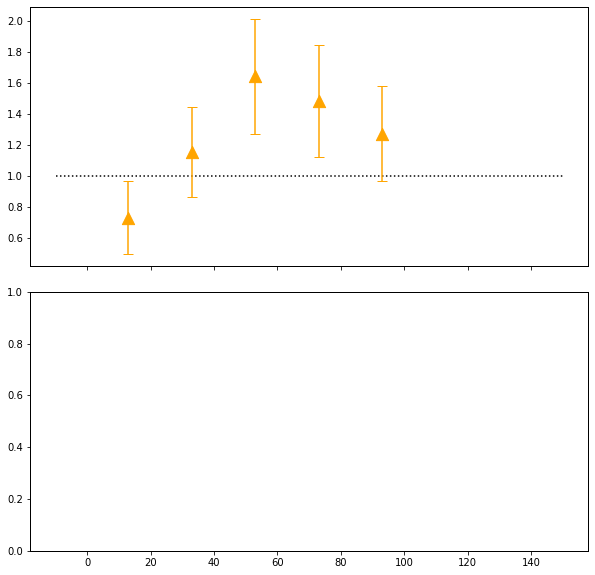

In [71]:
# get this into pretation form:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10), sharex=True)
fig.subplots_adjust(hspace=0.1)

kpc_meds = np.array(kpc_meds)

ax[0].plot([-10,150], [1,1], color='black', linestyle=':', zorder=1)
# ax[0].scatter(Ell13_x, Ell13_enh, s=50, color='black', marker='D', zorder=2)
# ax[0].errorbar(Ell13_x, Ell13_enh, yerr=Ell13_enherr, linestyle='none', capsize=5, color='black', zorder=2)
# ax[0].scatter(Sha20_x, Sha20_enh, s=50, color='red', marker='o', zorder=2)
# ax[0].errorbar(Sha20_x, Sha20_enh, yerr=(Sha20_enherrL, Sha20_enherrU), linestyle='none', capsize=5, 
#                color='red', zorder=2)
## plot V < 1000
######################
# ax[0].scatter(kpc_meds, Enh_X1000, s=150, color='cornflowerblue', marker='p', zorder=2)
# ax[0].errorbar(kpc_meds, Enh_X1000, yerr=(Enh_X_err1000,Enh_X_err1000), linestyle="None", capsize=5, 
#                color='cornflowerblue', zorder=2)
# ## plot V < 500
# ax[0].scatter(kpc_meds+3, Enh_X500, s=150, marker='^', color='orange', zorder=2)
# ax[0].errorbar(kpc_meds+3, Enh_X500, yerr=(Enh_X_err500,Enh_X_err500), linestyle="None", capsize=5, color='orange', zorder=2)
######################
ax[0].scatter(kpc_meds+3, Enh_X500, s=150, color='orange', marker='^', zorder=2)
ax[0].errorbar(kpc_meds+3, Enh_X500, yerr=(Enh_X_err500,Enh_X_err500), linestyle="None", capsize=5, 
               color='orange', zorder=2)
## plot V < 500
ax[0].scatter(kpc_meds, Enh_X1000, s=100, marker='p', color='green', zorder=2)
ax[0].errorbar(kpc_meds, Enh_X1000, yerr=(Enh_X_err1000,Enh_X_err1000), linestyle="None", capsize=5, color='green', zorder=2)
ax[0].text(70,4.3,'X-ray AGN', fontsize=25)
# ax[0].text(110,4.3,'X-ray AGN', fontsize=25)
# ax[0].scatter(90, 3.8, s=150, marker='p', color='cornflowerblue')
# ax[0].scatter(90, 3.4, s=150, marker='^', color='orange')
# ax[0].text(95, 3.7, '$\Delta V < 1000$', fontsize=20)
# ax[0].text(95, 3.3, '$\Delta V < 500$', fontsize=20)
# plot the shapes so I can then create a legend from it:
ax[0].scatter(50, 3.9, s=100, color='green', marker='p')
ax[0].scatter(50, 3.5, s=100, color='orange', marker='^')
# ax[0].scatter(50, 3.1, s=150, color='cornflowerblue', marker='p')
ax[0].text(53, 3.8, 'log($L_X$) > 43.7 erg s$^{-1}$ (0.5 < z < 3)', fontsize=13) #log($L_X$) > 43.7 (0.5 < z < 3)
ax[0].text(53, 3.4, '42 < log($L_X$) < 43.7 erg s$^{-1}$ (0.5 < z < 2)', fontsize=13)
# ax[0].text(53, 3, 'This Work (0.5 < z < 3.0)', fontsize=13)

# ax[0].text(72,3.3,'X-ray AGN', fontsize=25)
# plot the shapes so I can then create a legend from it:
# ax[0].scatter(75, 3.9, s=50, color='black', marker='D')
# ax[0].scatter(75, 3.5, s=50, color='red', marker='o')
# ax[0].text(80, 3.8, 'Ellison et al. 2013 (0.01 < z < 0.2)', fontsize=13)
# ax[0].text(80, 3.4, 'Shah et al. 2020 (0.5 < z < 3.0)', fontsize=13)

ax[1].plot([-5,150], [1,1], color='black', linestyle=':', zorder=1)

# ax[1].scatter(Sat14_x, Sat14_enh, s=50, color='black', marker='D', zorder=2)
# ax[1].errorbar(Sat14_x, Sat14_enh, yerr=Sat14_enherr, linestyle='none', capsize=5, color='black', zorder=2)
# ax[1].scatter(ShaIR20_x, ShaIR20_enh, s=50, color='red', marker='o', zorder=2)
# ax[1].errorbar(ShaIR20_x, ShaIR20_enh, yerr=(ShaIR20_enherrL, ShaIR20_enherrU), linestyle='none', capsize=5, 
#                color='red', zorder=2)
#############################
# ax[1].scatter(kpc_meds, Enh_DoIR500, s=150, color='orange', marker='^', zorder=2)
# ax[1].errorbar(kpc_meds, Enh_DoIR500, yerr=(Enh_DoIR_err1000,Enh_DoIR_err1000), linestyle="None", capsize=5, 
#                color='orange', zorder=2)

#############################

ax[1].text(80,4.3,'IR AGN', fontsize=25)
# plot the shapes so I can then create a legend from it:
ax[1].scatter(50, 3.9, s=50, color='black', marker='D')
ax[1].scatter(50, 3.5, s=50, color='red', marker='o')
ax[1].scatter(50, 3.1, s=150, color='cornflowerblue', marker='p')
ax[1].text(53, 3.8, 'Satyapal et al. 2014 (0.01 < z < 0.2)', fontsize=13)
ax[1].text(53, 3.4, 'Shah et al. 2020 (0.5 < z < 3.0)', fontsize=13)
ax[1].text(53, 3, 'This Work (0.5 < z < 3.0), Obscured', fontsize=13)

ax[1].scatter(kpc_meds+3, Enh_DoIR500, s=150, color='orange', marker='^', zorder=2)
ax[1].errorbar(kpc_meds+3, Enh_DoIR500, yerr=(Enh_DoIR_err500,Enh_DoIR_err500), linestyle="None", capsize=5, 
               color='orange', zorder=2)
ax[1].scatter(kpc_meds, Enh_DoIR1000, s=100, marker='p', color='green', zorder=2)
ax[1].errorbar(kpc_meds, Enh_DoIR1000, yerr=(Enh_DoIR_err1000,Enh_DoIR_err1000), linestyle="None", capsize=5, color='green', zorder=2)
# ax[1].scatter(90, 3.8, s=150, marker='p', color='cornflowerblue')
# ax[1].scatter(90, 3.4, s=150, marker='^', color='orange')
# ax[1].text(95, 3.7, '$\Delta V < 1000$', fontsize=20)
# ax[1].text(95, 3.3, '$\Delta V < 500$', fontsize=20)
# ax[1].text(80,3.3,'IR AGN', fontsize=25)
# plot the shapes so I can then create a legend from it:
# ax[1].scatter(50, 3.9, s=50, color='black', marker='D')
# ax[1].scatter(50, 3.5, s=50, color='red', marker='o')
# ax[1].text(53, 3.8, 'Satyapal et al. 2014 (0.01 < z < 0.2)', fontsize=13)
# ax[1].text(53, 3.4, 'Shah et al. 2020 (0.5 < z < 3.0)', fontsize=13)


ax[0].set_ylim(0,5)
ax[0].set_xlim(0,100)
# ax[0].set_xlabel('projected separation (kpc)')
ax[0].set_ylabel('AGN Enhancement', fontsize=20)
ax[0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
ax[1].set_ylim(0,5)
ax[1].set_xlim(0,100)
ax[1].set_xlabel('Projected Separation (kpc)', fontsize=20)
ax[1].set_ylabel('AGN Enhancement', fontsize=20)
ax[1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# mpl.rcParams['axes.linewidth'] = 1 #set the value globally
plt.savefig('/data/c1029594/CANDELS_AGN_merger_code/figs/AGNenh_XRAY.png')


plt.show()

In [39]:
kpc_meds

[10.0, 30.0, 50.0, 70.0, 90.0]

In [247]:
Enh_oDoIR, Enh_oDoIR_err

(array([2.44140481, 1.51379894, 1.16277377, 0.93493344, 0.87897816]),
 array([0.69410934, 0.3347904 , 0.21749968, 0.18470609, 0.15305684]))

In [293]:
Enh_DoIR

array([0.67310768, 1.18275614, 1.17769508, 1.06462267, 1.20745835,
       0.96813085, 0.9789906 , 1.38167239, 0.94800227, 0.59463601])

In [71]:
pXAGN_fracs, pDoAGN_fracs, pStAGN_fracs

(array([0.02454629, 0.02651553, 0.02149784, 0.0271006 , 0.01665283,
        0.02672383]),
 array([0.02043843, 0.00984546, 0.00678419, 0.01494517, 0.00962213,
        0.00866982]),
 array([0.06734036, 0.05835815, 0.03867802, 0.05073878, 0.03989056,
        0.0414508 ]))

In [190]:
pXAGN_fracs, pDoAGN_fracs, pStAGN_fracs

(array([0.06208329, 0.0696223 , 0.07753329, 0.0793333 , 0.10215264,
        0.09556594, 0.08401293, 0.12096029, 0.12363389, 0.07294994]),
 array([0.03546641, 0.01329185, 0.01880243, 0.00753347, 0.02407583,
        0.03033725, 0.01876051, 0.01841249, 0.01288801, 0.01071096]),
 array([0.04636903, 0.0395593 , 0.06037143, 0.05303263, 0.06296001,
        0.04780623, 0.0679829 , 0.05691904, 0.04927915, 0.06685776]))

In [191]:
iStfrac_err

array([0.02165872, 0.01515925, 0.01683642, 0.01116248, 0.01837127,
       0.00811019, 0.01621826, 0.0135589 , 0.01661353, 0.00865474])

In [192]:
rdf

,prime_index,partner_index,arc_sep,mass_ratio,kpc_sep,prime_ID,partner_ID,prime_z,prime_zt,partner_z,partner_zt,prime_M,partner_M,prime_LX,partner_LX,prime_PDFsig,partner_PDFsig,prime_CH1_FLUX,prime_CH2_FLUX,prime_CH3_FLUX,prime_CH4_FLUX,partner_CH1_FLUX,partner_CH2_FLUX,partner_CH3_FLUX,partner_CH4_FLUX,prime_CH1_FLUXERR,prime_CH2_FLUXERR,prime_CH3_FLUXERR,prime_CH4_FLUXERR,partner_CH1_FLUXERR,partner_CH2_FLUXERR,partner_CH3_FLUXERR,partner_CH4_FLUXERR,prime_IR_AGN_DON,prime_IR_AGN_STR,partner_IR_AGN_DON,partner_IR_AGN_STR,field,pair_prob,pair_ID,pXAGN_1,pXAGN_2,pDoAGN_1,pDoAGN_2,poDoAGN_1,poDoAGN_2,pStAGN_1,pStAGN_2,pCH1_det_1,pCH1_det_2,pCH2_det_1,pCH2_det_2,pCH3_det_1,pCH3_det_2,pCH4_det_1,pCH4_det_2,pALL_det_1,pALL_det_2
0,0,1,16.231376,0.190000,102.166655,1,5,0.5303,s,2.75,p,10.430000,10.240000,-8.482902e+58,-2.807221e+60,0.000,0.384,76.361900,58.929800,49.558600,35.969700,2.826230,2.121980,4.579580,2.526120,0.139008,0.082204,0.591554,0.523036,0.133584,0.067141,0.606722,0.527717,0,0,0,0,GDS,4.544933e-18,GDS_1+5,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
1,0,5,15.084491,0.300000,94.947709,1,40,0.5303,s,1.14,p,10.430000,10.130000,-8.482902e+58,-4.529897e+59,0.000,0.133,76.361900,58.929800,49.558600,35.969700,21.797100,17.698800,12.061500,12.131400,0.139008,0.082204,0.591554,0.523036,0.124108,0.070294,0.537382,0.475548,0,0,0,0,GDS,5.774390e-18,GDS_1+40,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
2,0,6,10.765069,0.380000,67.759574,1,49,0.5303,s,2.09,p,10.430000,10.050000,-8.482902e+58,-1.618324e+60,0.000,0.331,76.361900,58.929800,49.558600,35.969700,5.358410,5.756520,5.387990,4.326360,0.139008,0.082204,0.591554,0.523036,0.119740,0.068781,0.461542,0.416690,0,0,0,0,GDS,5.551936e-18,GDS_1+49,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
3,0,1560,16.265666,0.340000,102.382492,1,26839,0.5303,s,1.87,p,10.430000,10.090000,-8.482902e+58,-1.288301e+60,0.000,0.205,76.361900,58.929800,49.558600,35.969700,1.140050,1.133780,1.556390,0.775154,0.139008,0.082204,0.591554,0.523036,0.124030,0.069072,0.569885,0.496951,0,0,0,0,GDS,1.387987e-18,GDS_1+26839,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0
4,1,1560,5.481748,0.150000,43.251977,5,26839,2.7500,p,1.87,p,10.240000,10.090000,-2.807221e+60,-1.288301e+60,0.384,0.205,2.826230,2.121980,4.579580,2.526120,1.140050,1.133780,1.556390,0.775154,0.133584,0.067141,0.606722,0.527717,0.124030,0.069072,0.569885,0.496951,0,0,0,0,GDS,8.265261e-04,GDS_5+26839,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12546,1969,1962,11.382614,0.192278,95.923690,27156,27035,1.3900,p,1.16,p,10.390935,10.198657,-6.923361e+59,-4.702803e+59,0.066,0.099,14.116945,15.429913,9.153553,7.726377,16.939995,15.126205,12.206712,8.252580,0.056933,0.068932,1.453104,1.352100,0.059232,0.070706,1.505660,1.613910,0,0,0,0,UDS,1.146503e-04,UDS_27156+27035,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
12547,1970,98,5.775764,0.949509,46.734023,27729,1646,2.4700,p,2.89,p,11.340444,10.390935,-2.267588e+60,-3.095726e+60,3.116,0.123,8.346484,5.254411,9.094335,7.159568,10.385306,10.798994,13.398704,3.575131,0.051806,0.067381,1.090038,1.865503,0.061177,0.080680,1.280645,2.253612,0,0,0,0,UDS,3.137782e-02,UDS_27729+1646,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,1,0
12548,1970,122,15.168050,0.728721,122.730777,27729,2134,2.4700,p,2.02,p,11.340444,10.611723,-2.267588e+60,-1.509576e+60,3.116,0.141,8.346484,5.254411,9.094335,7.159568,14.239613,17.946718,18.137062,11.661051,0.051806,0.067381,1.090038,1.865503,0.071785,0.094422,1.484050,2.562993,0,0,0,0,UDS,8.355221e-03,UDS_27729+2134,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
12549,1971,728,8.104564,0.249877,63.401161,30325,10087,2.8400,p,2.38,p,10.283301,10.033424,-2.991284e+60,-2.104997e+60,5.767,0.132,0.015228,0.336702,4.682525,0.193730,2.808669,3.060772,3.315414,1.400104,0.079034,0.097082,2.616468,2.175052,0.053574,0.065165,1.569125,1.309219

In [193]:
df = bin_dfs['0.0-15.0'] # 30.0-45.0
df.loc[ df['prime_IR_AGN_DON'] > 0, ['prime_z','prime_M','prime_ID', 'prime_LX', 'prime_IR_AGN_DON', 'prime_IR_AGN_STR', 'prime_DALE_AGN_FLAG', 'field' ]]

KeyError: '0.0-15.0'

In [ ]:
# Now think about control galaxy selection... 
# the general idea now is to use the distribution of redshift, mass, and and sigma to get control selection
# from purely the fractional pair counts...

# but first we need to get some numbers... I want to know for each field
# 1) total isolated sample simply from initial projected pair analysis
# 2) how many would be added back with the introduction of a bottoming out
# 3) the percent change that bottoming out would have...
# perhaps I should do this in a separate notebook...

In [ ]:
data = np.array([pX_fr, pX_lerr, pX_uerr, pDo_fr, pDo_lerr, pDo_uerr, pSt_fr, pSt_lerr, pSt_uerr])
df = pd.DataFrame(data)
df = df.T
df = df.rename(columns={0:'pX_fr',1:'pX_lerr',2:'pX_uerr',
                        3:'pDo_fr',4:'pDo_lerr',5:'pDo_uerr',
                        6:'pSt_fr',7:'pSt_lerr',8:'pSt_uerr'})
# df.to_csv(PATH+'conv_results.csv', index=False)

In [ ]:
# save all the plotting data as a df
# bins as rows, columns are 

## General property distributions

In [273]:
# load up the dfs, make the same cuts, add AGN information and proceed:
# load in catalogs: <== specify column dtypes
fields = ['GDS','GDN','EGS','COS','UDS','COSMOS']
# fields = ['COS']
# fields = ['COSMOS']
all_dfs_dict = {}
LX_AGN = 42
mass_lo=9
sigma_cut=10
z_type = 'ps'
full_SPLASH = False

for field in fields:
    if field == 'COSMOS':
        df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                        dtype={'ZSPEC_R':object})
        
        df = df.loc[ (df['LP_TYPE'] != 1) & (df['LP_TYPE'] != -99) & (df['MASS'] > mass_lo) & # (mass_lo-1)
             (df['SIG_DIFF'] > 0) & (df['HSC_i_MAG_AUTO'] < 26) ]
        # df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS_FARMER_select.csv',
        #                 dtype={'ZSPEC_R':object})
        # # df = df.loc[ (df['VALID_SOURCE'] == True) & (df['MASS'] > (mass_lo)) & # (mass_lo-1)
        # #     (df['FLAG_COMBINED'] == 0) & (df['SIG_DIFF'] > 0)]
        # df = df.loc[ (df['lp_type'] != 1) & (df['lp_type'] != -99) & (df['lp_MASS'] > mass_lo) & (df['lp_MASS'] < 12) &
        #         (df['FLAG_COMBINED'] == 0) & (df['lp_SIG_DIFF'] > 0) ] #& (df['HSC_i_MAG'] < 25) ]
        # df = df.rename(columns={'lp_MASS':'MASS','lp_ZPHOT_PEAK':'ZPHOT_PEAK'})
        if full_SPLASH == True:
            df = df.drop(columns={'IRAC_CH1_FLUX', 'IRAC_CH1_FLUXERR', 'IRAC_CH2_FLUX', 'IRAC_CH2_FLUXERR'})
            df = df.rename(columns={'SPLASH_CH1_FLUX':'IRAC_CH1_FLUX', 'SPLASH_CH1_FLUXERR':'IRAC_CH1_FLUXERR',
                                    'SPLASH_CH2_FLUX':'IRAC_CH2_FLUX', 'SPLASH_CH2_FLUXERR':'IRAC_CH2_FLUXERR',
                                    'SPLASH_CH3_FLUX':'IRAC_CH3_FLUX', 'SPLASH_CH3_FLUXERR':'IRAC_CH3_FLUXERR',
                                    'SPLASH_CH4_FLUX':'IRAC_CH4_FLUX', 'SPLASH_CH4_FLUXERR':'IRAC_CH4_FLUXERR'})
        elif full_SPLASH == False:
            df = df.rename(columns={'SPLASH_CH3_FLUX':'IRAC_CH3_FLUX', 'SPLASH_CH3_FLUXERR':'IRAC_CH3_FLUXERR',
                                    'SPLASH_CH4_FLUX':'IRAC_CH4_FLUX', 'SPLASH_CH4_FLUXERR':'IRAC_CH4_FLUXERR'})
            
    else:
        df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                        dtype={'ZSPEC_R':object})
        df = df[ (df['CLASS_STAR'] < 0.9) & (df['PHOTFLAG'] == 0) & (df['MASS'] > (mass_lo)) & 
            (df['SIG_DIFF'] < sigma_cut) ]
    df = df.reset_index(drop=True)
    
    # calculate AB mags:
    df['IRAC_CH1_ABMAG'] = F2m(df['IRAC_CH1_FLUX'], 1)
    df['IRAC_CH2_ABMAG'] = F2m(df['IRAC_CH2_FLUX'], 2)
    df['IRAC_CH3_ABMAG'] = F2m(df['IRAC_CH3_FLUX'], 3)
    df['IRAC_CH4_ABMAG'] = F2m(df['IRAC_CH4_FLUX'], 4)
    
    # first thing is change df based on z_type
    df['z'] = df['ZPHOT_PEAK']
    if z_type == 'ps':
        df.loc[ df['ZBEST_TYPE'] == 's', 'z' ] = df['ZSPEC']
        df.loc[ df['ZBEST_TYPE'] == 's', 'SIG_DIFF' ] = 0
        
    all_df = df.loc[ (df['z'] >= 0.5) & (df['z'] <= 3.0) ].reset_index(drop=True)
    # all_df = df
    
    # calculate LX
    all_df['LX'] = ( all_df['FX'] * 4 * np.pi * ((cosmo.luminosity_distance(all_df['z']).to(u.cm))**2).value * 
                                                                ((1+all_df['z'])**(gamma-2)) )
   # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    
    # Flag IR AGN based on Donley and Stern
    # look at IR luminosities
    all_df['IR_AGN_DON'] = [0]*len(all_df)
    all_df['IR_AGN_STR'] = [0]*len(all_df)

    all_df.loc[ (np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']) >= 0.08) &
               (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) >= 0.15) &
               (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) >= (1.21*np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']))-0.27) &
               (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) <= (1.21*np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']))+0.27) &
               (all_df['IRAC_CH2_FLUX'] > all_df['IRAC_CH1_FLUX']) &
               (all_df['IRAC_CH3_FLUX'] > all_df['IRAC_CH2_FLUX']) &
               (all_df['IRAC_CH4_FLUX'] > all_df['IRAC_CH3_FLUX']), 'IR_AGN_DON'] = 1
    
    # zero magnitude fluxes:
    F03p6 = 280.9 #±4.1 Jy
    F04p5 = 179.7 #±2.6 Jy
    F05p8 = 115.0 #±1.7 Jy
    F08p0 = 64.9 #±0.9 Jy 
    all_df.loc[ (2.5*np.log10(F05p8 / (all_df['IRAC_CH3_FLUX']/1e6)) - 2.5*np.log10(F08p0 / (all_df['IRAC_CH4_FLUX']/1e6)) > 0.6) &
               (2.5*np.log10(F03p6 / (all_df['IRAC_CH1_FLUX']/1e6)) - 2.5*np.log10(F04p5 / (all_df['IRAC_CH2_FLUX']/1e6)) > 
               0.2 * (2.5*np.log10(F05p8 / (all_df['IRAC_CH3_FLUX']/1e6)) - 2.5*np.log10(F08p0 / (all_df['IRAC_CH4_FLUX']/1e6))) + 0.18) &
               (2.5*np.log10(F03p6 / (all_df['IRAC_CH1_FLUX']/1e6)) - 2.5*np.log10(F04p5 / (all_df['IRAC_CH2_FLUX']/1e6)) > 
                2.5 * (2.5*np.log10(F05p8 / (all_df['IRAC_CH3_FLUX']/1e6)) - 2.5*np.log10(F08p0 / (all_df['IRAC_CH4_FLUX']/1e6))) - 3.5),
               'IR_AGN_STR'] = 1
    
    # set the ones with incomplete data back to 0: POTENTIALLY UNECESSARY NOW (BELOW)
    all_df.loc[ (all_df['IRAC_CH1_FLUX'] <= 0) | (all_df['IRAC_CH2_FLUX'] <= 0) |
               (all_df['IRAC_CH3_FLUX'] <= 0) | (all_df['IRAC_CH4_FLUX'] <= 0), ['IR_AGN_DON', 'IR_AGN_STR'] ] = 0
    all_df.loc[ (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] < 5) | (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] < 5) |
               (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] < 5) | (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] < 5),
              ['IR_AGN_DON', 'IR_AGN_STR'] ] = 0
    # if field == 'COSMOS':
    #     all_df.loc[ (all_df['IRAC_CH1_ABMAG'] > 25.7) | (all_df['IRAC_CH2_ABMAG'] > 25.6) |
    #                (all_df['IRAC_CH3_ABMAG'] > 22.6) | (all_df['IRAC_CH4_ABMAG'] > 22.5), 
    #                ['IR_AGN_DON', 'IR_AGN_STR'] ] = 0
    
    # now just take the information that we need
    all_df['field'] = [field]*len(all_df)
    all_df['X_AGN'] = [0]*len(all_df)
    #### all_df.loc[ np.log10(all_df['LX']) > LX_AGN, 'X_AGN' ] = 1
    
    # m1 = np.min(all_df.loc[ (all_df['IRAC_CH1_FLUX'] > 0) & (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] >= 3), 'IRAC_CH1_FLUX' ])*1e-6
    # m2 = np.min(all_df.loc[ (all_df['IRAC_CH2_FLUX'] > 0) & (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] >= 3), 'IRAC_CH2_FLUX' ])*1e-6
    # m3 = np.min(all_df.loc[ (all_df['IRAC_CH3_FLUX'] > 0) & (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] >= 3), 'IRAC_CH3_FLUX' ])*1e-6
    # m4 = np.min(all_df.loc[ (all_df['IRAC_CH4_FLUX'] > 0) & (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] >= 3), 'IRAC_CH4_FLUX' ])*1e-6
    # m1 = np.min(all_df.loc[ (all_df['IRAC_CH1_FLUX'] > 0), 'IRAC_CH1_FLUX' ])
    # m2 = np.min(all_df.loc[ (all_df['IRAC_CH2_FLUX'] > 0), 'IRAC_CH2_FLUX' ])
    # m3 = np.min(all_df.loc[ (all_df['IRAC_CH3_FLUX'] > 0), 'IRAC_CH3_FLUX' ])
    # m4 = np.min(all_df.loc[ (all_df['IRAC_CH4_FLUX'] > 0), 'IRAC_CH4_FLUX' ])
    # print(field, m1, m2, m3, m4)
    # print(field, F2m(m1,1), F2m(m2,2), F2m(m3,3), F2m(m4,4))
    
    # add full ch detection flags:
    all_df['CH1_det'] = [0]*len(all_df)
    all_df['CH2_det'] = [0]*len(all_df)
    all_df['CH3_det'] = [0]*len(all_df)
    all_df['CH4_det'] = [0]*len(all_df)
    all_df.loc[ (all_df['IRAC_CH1_FLUX'] > 0) & (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] >= 5), 'CH1_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH2_FLUX'] > 0) & (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] >= 5), 'CH2_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH3_FLUX'] > 0) & (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] >= 5), 'CH3_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH4_FLUX'] > 0) & (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] >= 5), 'CH4_det' ] = 1
                                 
    all_dfs_dict[field] = all_df.loc[:, ['field','ID','z','MASS','LX','X_AGN','IR_AGN_DON','IR_AGN_STR', 
                                        'IRAC_CH1_FLUX','IRAC_CH1_FLUXERR','IRAC_CH1_ABMAG','CH1_det',
                                        'IRAC_CH2_FLUX','IRAC_CH2_FLUXERR','IRAC_CH2_ABMAG','CH2_det',
                                        'IRAC_CH3_FLUX','IRAC_CH3_FLUXERR','IRAC_CH3_ABMAG','CH3_det',
                                        'IRAC_CH4_FLUX','IRAC_CH4_FLUXERR','IRAC_CH4_ABMAG','CH4_det']]
    

/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas

In [274]:
all_dfs = pd.concat(all_dfs_dict, ignore_index=True)

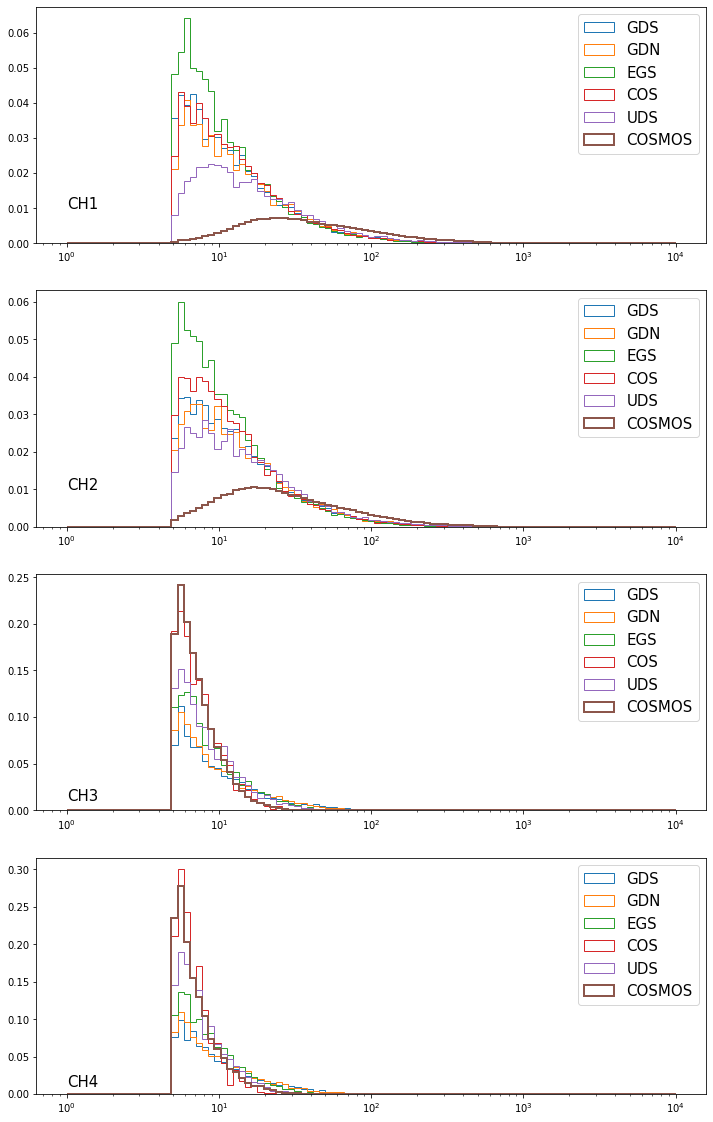

In [275]:
# make IRAC flux plots for detections:
fields = ['GDS','GDN','EGS','COS','UDS','COSMOS']
chs = ['1','2','3','4']
ratbins = np.logspace(0,4,100)
fig, ax = plt.subplots(nrows=4,ncols=1, figsize=(12,20))
for i, ch in enumerate(chs):
    for field in fields:
        sig_rat = (all_dfs.loc[ (all_dfs['field'] == field) & (all_dfs['CH'+ch+'_det'] == 1), 'IRAC_CH'+ch+'_FLUX' ] / 
                   all_dfs.loc[ (all_dfs['field'] == field) & (all_dfs['CH'+ch+'_det'] == 1), 'IRAC_CH'+ch+'_FLUXERR' ])
        if field == 'COSMOS':
            ax[i].hist(sig_rat, bins=ratbins, histtype='step', density=True, label=field, lw=2)
        else:
            ax[i].hist(sig_rat, bins=ratbins, histtype='step', density=True, label=field)
        ax[i].set_xscale('log')
        
    ax[i].legend(fontsize=15)
    ax[i].text(1,0.01, 'CH'+ch, fontsize=15)
        
plt.show()
        

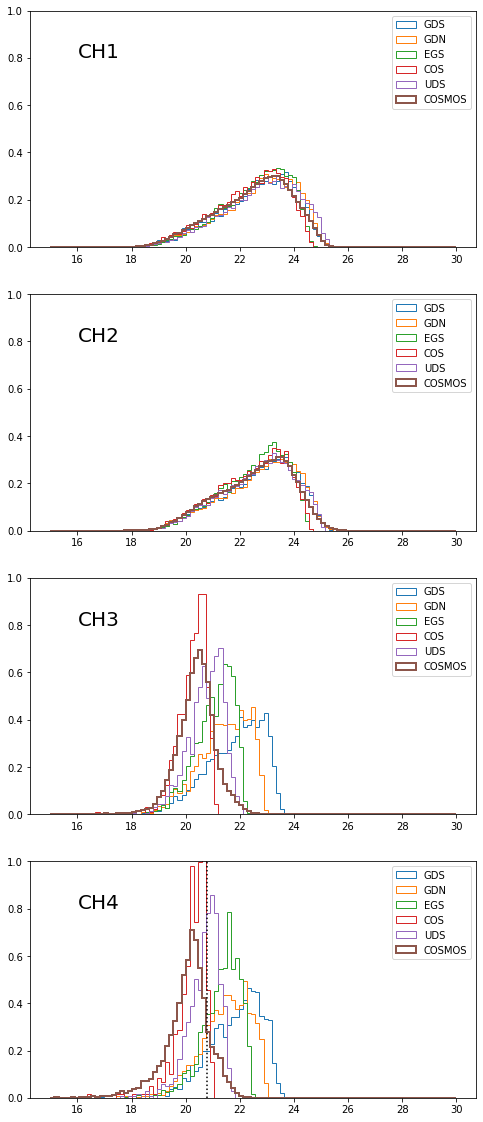

In [281]:
chs = ['1','2','3','4']
xbins = np.linspace(15,30,100)
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,20))
for i, ch in enumerate(chs):
    for field in fields:
        fdf = all_dfs.loc[ (all_dfs['field'] == field) & (all_dfs['CH'+ch+'_det'] == 1) ]
        if field == 'COSMOS':
            ax[i].hist(fdf['IRAC_CH'+ch+'_ABMAG'], bins=xbins, density=True, histtype='step', lw=2, label=field)
        else:
            ax[i].hist(fdf['IRAC_CH'+ch+'_ABMAG'], bins=xbins, density=True, histtype='step', label=field)
    
    # plt.plot([22.5,22.5],[0,100], color='black', linestyle = ':')
    ax[i].set_ylim(0,1)
    ax[i].legend()
    ax[i].text(16,0.8,'CH'+ch, fontsize=20)
    
    if ch == '1':
        ax[i].plot([20.8,20.8],[0,1], color='black', linestyle=':')
plt.show()

In [136]:
X_df = all_dfs.loc[ all_dfs['X_AGN'] == 1]
DON_df = all_dfs.loc[ all_dfs['IR_AGN_DON'] == 1]
STR_df = all_dfs.loc[ all_dfs['IR_AGN_STR'] == 1]

In [137]:
DON_df.loc[ DON_df['field'] == 'COSMOS', 'IRAC_CH4_FLUX' ].describe()
# we need to recreate the same selection criterea that Donley used...
# 1058 (1172) Donley in SPLASH
# 1038 (1140) in DAWN+SPLASH...

count    1315.000000
mean      154.140162
std       322.375550
min         3.931992
25%        32.345226
50%        69.856964
75%       164.119860
max      6295.710000
Name: IRAC_CH4_FLUX, dtype: float64

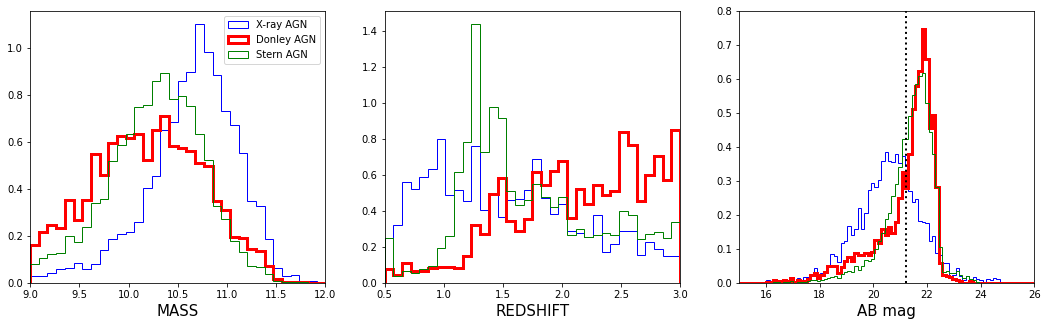

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
mbins = np.linspace(9,12,35)
zbins = np.linspace(0.5,3,35)
magbins = np.linspace(15,30,120)

ax[0].hist(X_df['MASS'], bins=mbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='blue')
ax[0].hist(DON_df['MASS'], bins=mbins, density=True, cumulative=False, histtype='step', label='Donley AGN', color='red',
          lw=3)
ax[0].hist(STR_df['MASS'], bins=mbins, density=True, cumulative=False, histtype='step', label='Stern AGN', color='green')
ax[0].set_xlim(9,12)
# ax[0].set_yscale('log')
ax[0].legend(loc=1)
ax[0].set_xlabel('MASS', fontsize=15)

ax[1].hist(X_df['z'], bins=zbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='blue')
ax[1].hist(DON_df['z'], bins=zbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='red',
          lw=3)
ax[1].hist(STR_df['z'], bins=zbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='green')
# ax[1].set_yscale('log')
ax[1].set_xlim(0.5,3)
ax[1].set_xlabel('REDSHIFT', fontsize=15)

ax[2].hist(X_df['IRAC_CH4_ABMAG'], bins=magbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='blue')
ax[2].hist(DON_df['IRAC_CH4_ABMAG'], bins=magbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='red',
          lw=3)
ax[2].hist(STR_df['IRAC_CH4_ABMAG'], bins=magbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='green')
# ax[1].set_yscale('log')
ax[2].plot([21.2,21.2],[0,1], color='black', linestyle=':', lw=2)
ax[2].set_ylim(0,0.8)
ax[2].set_xlim(15,26)
ax[2].set_xlabel('AB mag', fontsize=15)

plt.show()

In [ ]:
# redshift vs LX per field:
colors = ['firebrick','navy','green','tomato','cornflowerblue','cornflowerblue']
markers = ['x','D','^','v','o','.']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

ax.set_xlim(0.5,3)
ax.set_ylim(42,46)
ax.set_xlabel('z', fontsize=20)
ax.set_ylabel('$L_X$', fontsize=20)
ax.plot([0.5,3],[43.7,43.7], color='black')
ax.plot([0.5,2],[43.2,43.2], color='black')
ax.plot([2,2],[42,43.7], color='black')
ax.add_patch(Rectangle((0.5,43.7), 2.5, 4, facecolor='lightsteelblue', alpha=0.3))
ax.add_patch(Rectangle((0.5,43.2), 1.5, 0.5, facecolor='purple', alpha=0.1))
ax.add_patch(Rectangle((0.5,42), 1.5, 1.2, facecolor='red', alpha=0.1))

for i, field in enumerate(fields):
    fdf = X_df.loc[ X_df['field'] == field ]
    plt.scatter( fdf['z'], np.log10(fdf['LX']), color=colors[i], marker=markers[i], label=field, zorder=-1*i )
    
plt.legend(loc=2, fontsize=15)
    
plt.show()

In [ ]:
# so let's create a new df from rdf and add kpc<15 Pprobs:
key = '60.0-75.0'
df_dict = {'ID':ID_bin[key],
    'field':field_bin[key],
    'Pp':p_wprobs[key],
    'z':pz_bin[key],
    'MASS':pmass_bin[key],
    'X_AGN':pX_bin[key],
    'Do_AGN':pDo_bin[key],
    'St_AGN':pSt_bin[key]}
bin15_df = pd.DataFrame(df_dict)
X_df15 = bin15_df.loc[ bin15_df['X_AGN'] == 1]
DON_df15 = bin15_df.loc[ bin15_df['Do_AGN'] == 1]
STR_df15 = bin15_df.loc[ bin15_df['St_AGN'] == 1]

In [ ]:
fig, ax = plt.subplots(nrows=len(ID_bin), ncols=3, figsize=(20,100))
pbins = np.logspace(-12,0, 1000)
# pbins = np.linspace(10e-11,1, 1000000)
for i, key in tqdm(enumerate(ID_bin.keys())):
    pdf_dict = {'ID':ID_bin[key],
        'field':field_bin[key],
        'Pp':p_wprobs[key],
        'z':pz_bin[key],
        'MASS':pmass_bin[key],
        'X_AGN':pX_bin[key],
        'Do_AGN':pDo_bin[key],
        'St_AGN':pSt_bin[key]}
    idf_dict = {'ID':iID_bin[key],
        'field':ifield_bin[key],
        'Pp':i_wprobs[key],
        'z':iz_bin[key],
        'MASS':imass_bin[key],
        'X_AGN':iX_bin[key],
        'Do_AGN':iDo_bin[key],
        'St_AGN':iSt_bin[key]}
    pdf = pd.DataFrame(pdf_dict)
    idf = pd.DataFrame(idf_dict)
    pX_df = pdf.loc[ pdf['X_AGN'] == 1]
    poX_df = pdf.loc[ (pdf['Do_AGN'] != 1) & (pdf['X_AGN'] == 1) ]
    pDON_df = pdf.loc[ pdf['Do_AGN'] == 1]
    poDON_df = pdf.loc[ (pdf['Do_AGN'] == 1) & (pdf['X_AGN'] != 1) ]
    pSTR_df = pdf.loc[ pdf['St_AGN'] == 1]
    iX_df = idf.loc[ idf['X_AGN'] == 1]
    ioX_df = pdf.loc[ (idf['Do_AGN'] != 1) & (idf['X_AGN'] == 1) ]
    iDON_df = idf.loc[ idf['Do_AGN'] == 1]
    ioDon_df = pdf.loc[ (idf['Do_AGN'] == 1) & (idf['X_AGN'] != 1) ]
    iSTR_df = idf.loc[ idf['St_AGN'] == 1]
    
    
    p_Xc, p_Xb, p_Xp = ax[i,0].hist(pX_df['Pp'], bins=pbins, color='blue', density=True, cumulative=1, histtype='step',
                                   label='paired X-ray AGN')
    po_Xc, po_Xb, po_Xp = ax[i,0].hist(poX_df['Pp'], bins=pbins, color='deepskyblue', density=True, cumulative=1, histtype='step',
                                   label='paired X-ray AGN')
    p_Dc, p_Db, p_Dp = ax[i,0].hist(pDON_df['Pp'], bins=pbins, color='red', density=True, cumulative=1, histtype='step',
                                   label='paired Donley AGN')
    po_Dc, po_Db, po_Dp = ax[i,0].hist(poDON_df['Pp'], bins=pbins, color='violet', density=True, cumulative=1, histtype='step',
                                   label='paired only Donley AGN')
    # p_Sc, p_Sb, p_Sp = ax[i,0].hist(pSTR_df['Pp'], bins=pbins, color='green', density=True, cumulative=-1, histtype='step',
    #                                label='paired Stern AGN')
    i_Xc, i_Xb, i_Xp = ax[i,0].hist(iX_df['Pp'], bins=pbins, color='blue', density=True, cumulative=1, histtype='step', 
                 lw=0.5, linestyle='--', label='apple X-ray AGN')
    io_Xc, io_Xb, io_Xp = ax[i,0].hist(ioX_df['Pp'], bins=pbins, color='deepskyblue', density=True, cumulative=1, histtype='step',
                 lw=0.5, linestyle='--', label='apple X-ray AGN')
    i_Dc, i_Db, i_Dp = ax[i,0].hist(iDON_df['Pp'], bins=pbins, color='red', density=True, cumulative=1, histtype='step', 
                 lw=0.5, linestyle='--', label='apple Donley AGN')
    io_Dc, io_Db, io_Dp = ax[i,0].hist(ioDon_df['Pp'], bins=pbins, color='violet', density=True, cumulative=1, histtype='step',
                 lw=0.5, linestyle='--', label='apple only Donley AGN')
    # i_Sc, i_Sb, i_Sp = ax[i,0].hist(iSTR_df['Pp'], bins=pbins, color='green', density=True, cumulative=-1, histtype='step', 
    #              lw=0.5, linestyle='--', label='apple Stern AGN')
    
    ax[i,0].set_xscale('log')
    ax[i,0].set_yscale('log')
    ax[i,0].set_xlim(10e-12, 1)
    
    ax[i,0].set_xlabel('Pair Probability', fontsize=15)
    ax[i,0].set_ylabel('Cumulative Fraction', fontsize=15)
    ax[i,0].legend(fontsize=10, loc=4)    
    ax[i,0].set_title(key, fontsize=15)

    ax[i,1].stairs((p_Xc/i_Xc), p_Xb, fill=False, color='blue')
    ax[i,1].stairs((po_Xc/io_Xc), po_Xb, fill=False, color='deepskyblue')
    ax[i,1].stairs((p_Dc/i_Dc), p_Db, fill=False, color='red')
    ax[i,1].stairs((po_Dc/io_Dc), po_Db, fill=False, color='violet')
    # ax[i,1].stairs((p_Sc-i_Sc), p_Sb, fill=False, color='green')
    ax[i,1].plot([0,1],[1,1], color='black', linestyle=':')
    ax[i,1].set_xscale('log')
    ax[i,1].set_xlim(1e-5, 1)
    ax[i,1].set_ylim(0,2)
    ax[i,1].set_xlabel('Pair Probability', fontsize=15)
    ax[i,1].set_ylabel('Cumulative Fraction Difference', fontsize=15)
    
    # throw it into a ks test:
    D, p = scipy.stats.ks_2samp(poDON_df['Pp'], poX_df['Pp'], method='auto') 
    ax[i,2].stairs((po_Dc/p_Xc), p_Xb, fill=False, color='black')
    ax[i,2].stairs((io_Dc/i_Xc), p_Xb, fill=False, color='black', linestyle=':')
    ax[i,2].plot([0,1],[1,1], color='black', linestyle=':')
    ax[i,2].set_title('D = {0} // p = {1}'.format(round(D,3), round(p,3)))
    ax[i,2].set_xscale('log')
    ax[i,2].set_xlim(1e-5, 1)
    ax[i,2].set_ylim(0,2)
    ax[i,2].set_xlabel('Pair Probability', fontsize=15)

    
plt.show()

In [ ]:
poDON_df # / (po_Xc)

## pair fraction vs redshift

In [ ]:
# first thing to do is to load in CANDELS data and simply count all source in mass and z range
nPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/Pair Project - Updated Data/'
cPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
fields = ['GDS','EGS','COS','GDN','UDS','COSMOS']
field_pcounts = {}
all_pcounts = {}
field_counts = {}
all_counts = {}
zmins = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.5, 5.5]
zmaxs = [1, 1.5, 2, 2.5, 3, 3.5, 4.5, 5.5, 6.5]

# populate all dicts:
for i in range(0, len(zmins)):
    all_pcounts[str(zmins[i])+'-'+str(zmaxs[i])] = 0
    all_counts[str(zmins[i])+'-'+str(zmaxs[i])] = 0

# load in results:
# file = 'pair_prob/PP_ALL_FIELDS.csv'
file = 'conv_prob/CP_ALL_FIELDS.csv'
rdf = pd.read_csv(PATH+file)
# rdf['pair_prob'] = rdf['pair_prob']/100 # only for pp method

for field in fields:
    print(field)
    if field == 'COSMOS':
        df = pd.read_csv(cPATH+'select_COSMOS2020.csv')
        df['SIG_DIFF'] = df['lp_zPDF_u68'] - df['lp_zPDF_l68']
        df = df[ (df['lp_type'] != 1) & (df['lp_type'] != -99) & (df['lp_mass_med'] > 10.3) & 
           (df['FLAG_COMBINED'] == 0) & (df['lp_zPDF'] > 0.5) & (df['lp_zPDF'] < 6.5) ]
        df = df.rename(columns={'ALPHA_J2000':'RA', 'DELTA_J2000':'DEC', 'lp_mass_med':'MASS', 'lp_zPDF':'ZPHOT_PEAK',
                               'F0.5-10_2015':'FX', 'UVISTA_H_MAG_APER2':'HMAG'})
        all_df = df.reset_index(drop=True)
    else:
        df = pd.read_csv(nPATH+'CANDELS_Catalogs/CANDELS.'+field+'.1018.Lx_best.wFx_AIRD.csv')
        df_phot = pd.read_csv(nPATH+'redshift_catalogs.full/zcat_'+field+'_v2.0.cat', names=['file','ID','RA','DEC','z_best',
                        'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                        'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                        'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                        'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                        'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                        'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                        'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                        'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                        'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                        'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                           delimiter=' ', comment='#')
        # match based on ID as GDN has ID weirdness
        df_phot = df_phot.loc[ (df_phot['ID'].isin(df['ID']) == True) ]
        df_phot = df_phot.reset_index(drop=True)
        df['ZPHOT_PEAK'] = df_phot['mFDa4_z_peak'] # might want to use weight for consistency with COSMOS
        df['SIG_DIFF'] = df_phot['mFDa4_z683_high'] - df_phot['mFDa4_z683_low']
        df = df[ (df['CLASS_STAR'] < 0.9) & (df['PHOTFLAG'] == 0) & (df['MASS'] > 10.3) & 
                (df['ZPHOT_PEAK'] > 0.5) & (df['ZPHOT_PEAK'] < 6.5) ]
        all_df = df.reset_index(drop=True)
    
    pair_count = {}
    all_count = {}
    for i in range(0, len(zmins)):
        # for pairs
        zdf = rdf[ (rdf['kpc_sep'] >= 5) & (rdf['kpc_sep'] <= 30) & (rdf['mass_ratio'] < np.log10(4/1)) &
                 (rdf['prime_M'] > 10.3) & (rdf['prime_z'] >= zmins[i]) & (rdf['prime_z'] < zmaxs[i]) & 
                  (rdf['field'] == field) & (rdf['pair_prob'] > 0.01) ]
        pair_count[str(zmins[i])+'-'+str(zmaxs[i])] = np.sum(zdf['pair_prob'])
        all_pcounts[str(zmins[i])+'-'+str(zmaxs[i])] = all_pcounts[str(zmins[i])+'-'+str(zmaxs[i])] + np.sum(zdf['pair_prob'])
        
        # for all data
        zall_df = all_df[ (all_df['ZPHOT_PEAK'] >= zmins[i]) & (all_df['ZPHOT_PEAK'] < zmaxs[i]) ]
        all_count[str(zmins[i])+'-'+str(zmaxs[i])] = len(zall_df)
        all_counts[str(zmins[i])+'-'+str(zmaxs[i])] = all_counts[str(zmins[i])+'-'+str(zmaxs[i])] + len(zall_df)
        
    field_pcounts[field] = pair_count
    field_counts[field] = all_count
    
field_pcounts['ALL'] = all_pcounts
field_counts['ALL'] = all_counts

In [ ]:
pair_frac = {}
fields.append('ALL')
for field in field_pcounts:
    fracs = {}
    for zbin in field_pcounts[field]:
        fracs[zbin] = field_pcounts[field][zbin] / field_counts[field][zbin]
        pair_frac[field] = fracs

In [ ]:
# field_pcounts

In [ ]:
# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
colors = ['purple','red','green','blue','orange','pink','black']
for i, field in enumerate(field_pcounts):
    if field == 'ALL':
        ax.scatter(-1,-1, s=50, facecolor=colors[i], label=field)
    else:
        ax.scatter(-1,-1,s=25, edgecolor=colors[i], facecolor='none', label=field)
    for zbin in field_pcounts[field]:
        x = zbin.split('-')
        z = ((float(x[0]) + float(x[1])) / 2) + 0.02*i
        if field == 'ALL':
            ax.scatter(z, pair_frac[field][zbin], s=5, facecolor=colors[i])
        else:
            ax.scatter(z, pair_frac[field][zbin], s=25, edgecolor=colors[i], facecolor='none')
plt.yscale('log')
plt.ylim(0.001,1)
plt.xlim(0,6.5)
plt.legend()
plt.show()

In [ ]:
# rdf[ rdf['kpc_sep'] < 30 ]
#

## Update COSMOS for EAZY

In [ ]:
SIGMAS = np.array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
       -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
       -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
        1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
        3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ])

def zcdf_to_pdf(zcdf, sigmas=SIGMAS):
    """
    Convert compressed redshift CDF to PDF

    Parameters
    ----------
    zcdf : array-like
        Redshifts where ``cdf(z)`` for ``normal_cdf(mu=0, sigmas)``

    sigmas : array-like
        Values where ``normal_cdf`` is evaluated
    Returns
    -------
    pdf : array-like
        Converted ``p(z)``

    """
    import scipy.stats
    # Evaluate normal distribution at these values to get PDF(x)
    pdf_y = scipy.stats.norm.pdf(sigmas)
    return pdf_y #/ np.trapz(pdf_y, zcdf) # don't normalize untl after interpolation

In [ ]:
# load in the EAZY FARMER PDFs
EZ_PATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS2020_R1/PZ/'

with fits.open(EZ_PATH+'COSMOS2020_FARMER_R1_v2.0_EAZY_CZ.fits') as data:
    EZ_df = pd.DataFrame(data[1].data)
CDFz = np.array(EZ_df) # becomes an array in the column case

# define the z values:
z = np.linspace(0,10,1001)
# create the PDF array to fill:
PDF_array = np.zeros((len(CDFz), len(z)+1))
# fill with IDs and z array:
PDF_array[1:,0] = CDFz[1:,0]
PDF_array[0,1:] = z

# will need to run the interpolation in a for loop bc different x values:
for i in tqdm(range(1, len(CDFz)), miniters=100):
    
    Pz = zcdf_to_pdf(CDFz[i,1:])
    
    # fintp1 = interp1d(CDFz[i,1:], Pz, kind='linear', fill_value=(Pz[0],Pz[-1]), bounds_error=False)
    fintp1 = interp1d(CDFz[i,1:], Pz, kind='linear', fill_value=0, bounds_error=False)
    Pz_i = fintp1(z)
    
    # normalize and fill
    Pz_i = Pz_i / np.trapz(Pz_i, x=z)
    PDF_array[i,1:] = Pz_i


# PDF_array[1:0
hdu_dA = fits.PrimaryHDU(np.nan_to_num(PDF_array))
hdul_dA = fits.HDUList([hdu_dA])
hdul_dA.writeto(EZ_PATH+'COSMOS2020_FARMER_R1_v2.0_EAZY_PZ0.fits', overwrite=True)

In [ ]:
# plot test scripts:
idx = np.random.randint(0,len(CDFz),1)[0]
plt.plot(z, PDF_array[idx,1:])
plt.plot(CDFz[idx,1:], zcdf_to_pdf(CDFz[idx,1:]))
plt.show()

In [ ]:
# if it passes the test, save it here:
# save PdA arrays
hdu_dA = fits.PrimaryHDU(np.nan_to_num(PDF_array))
hdul_dA = fits.HDUList([hdu_dA])
hdul_dA.writeto(EZ_PATH+'COSMOS2020_FARMER_R1_v2.0_EAZY_PZ.fits.fits', overwrite=True)

In [ ]:
# based on the data I was using from COSMOS before, I need
# from EZ:
# mass, mask, type, z_phot_peak, 2sig, Hmag
# else from COSMOS:
# FX, IRAC stuff, FLAG_COMBINED, spec-z information ### TOMORROW ###
idx

In [ ]:
# stupid catalog fixing

CPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
with fits.open(CPATH+'CHANDRA_COSMOS/cCOSMOS_Civano16.fits') as data:
    cCHANDRA_arr = np.array(data[1].data)
cCHANDRA_arrf = cCHANDRA_arr.byteswap().newbyteorder()
cCHANDRA = pd.DataFrame(cCHANDRA_arrf)
# decode the df:
for col in cCHANDRA:
    cCHANDRA[col] = cCHANDRA[col].str.decode("utf-8").str.strip()
    cCHANDRA[col] = cCHANDRA[col].replace('---', '-99')
    if col != 'ID':
        cCHANDRA[col] = cCHANDRA[col].astype(float)
        
# and let's write this to a csv file for topcat:
cCHANDRA.to_csv(CPATH+'CHANDRA_COSMOS/cCOSMOS_Civano16.csv', index=False)

In [ ]:
# combine COSMOS CLASSIC and my CLASSIC catalog in here bc for whatever reason topcat can't handle 999999
# load in classic:
CPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
with fits.open(CPATH+'COSMOS2020_R1/COSMOS2020_CLASSIC_R1_v2.0.fits') as data:
    # fix big-endian buffer error
    cCOSMOS_arr = np.array(data[1].data)
cCOSMOS_arrf = cCOSMOS_arr.byteswap().newbyteorder()
COSMOS2020 = pd.DataFrame(cCOSMOS_arrf)
COSMOS2020 = COSMOS2020.fillna(-99)

# load in my narrowed down version:
myCOSMOS2020 = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/COSMOS_data.csv',
                        dtype={'ZSPEC_R':object})

# match the catalogs
COSMOS2020['myID'] = myCOSMOS2020['ID']
COSMOS2020['FX'] = myCOSMOS2020['FX']
COSMOS2020['ZSPEC'] = myCOSMOS2020['ZSPEC']
COSMOS2020['ZSPEC_R'] = myCOSMOS2020['ZSPEC_R']
COSMOS2020['ZBEST_TYPE'] = myCOSMOS2020['ZBEST_TYPE']

# save as a fits file probably:
t = Table.from_pandas(COSMOS2020)
t.write(CPATH+'COSMOS2020_R1/COSMOS2020_CLASSIC_R1_v2.0_wFX.fits', overwrite=True)

In [ ]:
# open new COSMOS to fill nan values:
CPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
COSMOS = pd.read_csv(CPATH+'COSMOS_FARMER_select.csv')
COSMOS = COSMOS.fillna(-99)
COSMOS.to_csv(CPATH+'COSMOS_FARMER_select.csv', index=False)

In [ ]:
# course of action:
# so it seems theres most likely a memory error in COSMOS CLASSIC LP, though is FARMER EZ will work...
#                                                                    then I'm not gonna worry about it

# maybe now I can try to parallelize the load_pdf bit to share the load of running PdA and conv_prob for low mass objects
# ---> optimized for column operations, so try to split into chunks then combine in post

a = np.linspace(0,100,34000)
# len(a)//10000
aa = np.linspace(0, len(a), len(a)//10000)

In [ ]:
# so I want to create these:
# [ [0:10000], [10000:] ]
# maybe I should tackle this with a for loop
# no I want to segment the range of ints as an array:
idx = np.linspace(0, len(a), len(a)+1, dtype=int)
split_arr = np.linspace(0, 1e7, 1001, dtype=int)
idx_splitter = np.split(idx, split_arr)
# now we wanna split this up every 10000
# will need to loop through idx_splitter to remove from the list empty arrays
fresh_list = []
for ob in idx_splitter:
    if np.any(ob.shape) != 0:
        fresh_list.append(ob)

In [ ]:
CPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
COSMOS = pd.read_csv(CPATH+'COSMOS_FARMER_select.csv')
COSMOS = COSMOS.fillna(-99)
COSMOS.to_csv(CPATH+'COSMOS_FARMER_select.csv', index=False)

In [ ]:
COSMOS.loc[COSMOS['ID'] == idx]

In [ ]:
COSMOS['ZBEST_TYPE'] = COSMOS['ZBEST_TYPE'].replace('-99', 'p')

In [ ]:
COSMOS.to_csv(CPATH+'COSMOS_FARMER_select.csv', index=False)

In [ ]:
COSMOS.loc[(COSMOS['ZPHOT_PEAK'] < 0) & (COSMOS['MASS'] > 0)]

In [ ]:
df = COSMOS
df = df.loc[ (df['VALID_SOURCE'] == True) & (df['MASS'] > (10)) & # (mass_lo-1)
            (df['FLAG_COMBINED'] == 0) & (df['SIG_DIFF'] > 0)]

In [ ]:
plt.hist(df['MASS'], 100)
plt.show()
# 93958
# 93963

In [ ]:
df.loc[ (df['MASS'] > 12) & (df['ZPHOT_PEAK'] < 3) ]

In [ ]:
EZ_PATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS2020_R1/PZ/'

with fits.open(EZ_PATH+'COSMOS2020_FARMER_R1_v2.0_EAZY_PZ0.fits') as data:
    # fix big endian buffer error:
    COSMOS_PZ_arr = np.array(data[0].data)
COSMOS_PZ_arrf = COSMOS_PZ_arr.byteswap().newbyteorder()
COSMOS_PZ = pd.DataFrame(COSMOS_PZ_arrf)
z_01 = COSMOS_PZ.loc[0,1:].to_numpy()
PDF_array = np.array(COSMOS_PZ) # becomes an array in the column case

with fits.open(EZ_PATH+'COSMOS2020_FARMER_R1_v2.0_EAZY_PZ.fits') as data:
    # fix big endian buffer error:
    COSMOS_PZ_arr = np.array(data[0].data)
COSMOS_PZ_arrf = COSMOS_PZ_arr.byteswap().newbyteorder()
COSMOS_PZ2 = pd.DataFrame(COSMOS_PZ_arrf)
z_01 = COSMOS_PZ.loc[0,1:].to_numpy()
PDF_array = np.array(COSMOS_PZ) # becomes an array in the column case

In [ ]:
df2 = COSMOS_PZ - COSMOS_PZ2

In [ ]:
bad_IDs = df2.loc[ df2[3] == 0 ].index

In [ ]:
COSMOS_PZ.loc[bad_IDs]

In [ ]:
COSMOS

In [ ]:
aa_milne_arr = ['pooh', 'rabbit', 'piglet', 'Christopher']
np.random.choice(aa_milne_arr)

In [ ]:
# COSMOS IRAC CH flux sensitivity:
# CH1:
# CH2:
# CH3:
# CH4:

## Add magnitudes to IRAC fluxes

In [264]:
def F2m(F, ch): # goes to Vega then to AB
    if ch == 1:
        F0 = 280.9
        K = 2.788
    elif ch == 2:
        F0 = 179.7
        K = 3.255
    elif ch == 3:
        F0 = 115
        K = 3.743
    elif ch == 4:
        F0 = 64.9
        K = 4.372
    return 2.5*np.log10(F0/(F*1e-6)) + K

In [2]:
# load in cats:
fields = ['GDS','GDN','EGS','COS','UDS','COSMOS']
# fields = ['COS']
# fields = ['COSMOS']
all_dfs_dict = {}
LX_AGN = 42
mass_lo=9
sigma_cut=10
z_type = 'ps'

for field in fields:
#     if field == 'COSMOS':
#         # df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
#         #                 dtype={'ZSPEC_R':object})
#         # df = df.loc[ (df['LP_TYPE'] != 1) & (df['LP_TYPE'] != -99) & (df['MASS'] > (mass_lo)) & # (mass_lo-1)
#         #     (df['FLAG_COMBINED'] == 0) & (df['SIG_DIFF'] < sigma_cut)]
#         df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS_FARMER_select.csv',
#                         dtype={'ZSPEC_R':object})

#     else:
    df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                    dtype={'ZSPEC_R':object})

    # calculate AB magnitudes and fill nan values with -99
    # df['IRAC_CH1_ABMAG'] = F2m(df['IRAC_CH1_FLUX'], 1)
    # df['IRAC_CH2_ABMAG'] = F2m(df['IRAC_CH2_FLUX'], 2)
    # df['IRAC_CH3_ABMAG'] = F2m(df['IRAC_CH3_FLUX'], 3)
    # df['IRAC_CH4_ABMAG'] = F2m(df['IRAC_CH4_FLUX'], 4)
    df = df.fillna(-99)
    
    # # resave:
    # if field == 'COSMOS':
    #     df.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS_FARMER_select.csv', index=False)
    # else:
    df.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv', index=False)
        


In [ ]:
# load in the matched C-COSMOS + FARMER catalog to investigate difference in IRAC magnitude estimates:
df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/CCOSMOS_FARMER.csv')
df = df.fillna(-99)

In [ ]:
# add columns showing the different in FARMER and CCOSMOS Mags:
df['F-C1'] = df['IRAC_CH1_ABMAG_F'] - df['IRAC_CH1_ABMAG_C']
df['F-C2'] = df['IRAC_CH2_ABMAG_F'] - df['IRAC_CH2_ABMAG_C']
df['F-C3'] = df['IRAC_CH3_ABMAG_F'] - df['IRAC_CH3_ABMAG_C']
df['F-C4'] = df['IRAC_CH4_ABMAG_F'] - df['IRAC_CH4_ABMAG_C']

In [ ]:
# let's plot these bad larry's:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
xbins = np.linspace(15,30,100)
ybins = np.linspace(-10,10,1000)
# ax[0,0].scatter( df['IRAC_CH1_ABMAG_F'], df['F-C1'], s=10, color='red', alpha=0.1 )
ax[0,0].hist2d( df['IRAC_CH1_ABMAG_F'], df['F-C1'], bins=[xbins,ybins], cmap='Reds' )
ax[0,0].plot([0,100],[0,0], color='black', linestyle='--')
ax[0,0].plot([25.7,25.7],[-2,2], color='blue', linestyle=':')
ax[0,0].set_xlim(15,26)
ax[0,0].set_ylim(-1,1)
ax[0,0].set_title('IRAC_CH1', fontsize=20)
ax[0,0].set_xlabel('FARMER AB MAG', fontsize=15)
ax[0,0].set_ylabel('FARMER - CANDELS AB MAG', fontsize=15)

ax[0,1].hist2d( df['IRAC_CH2_ABMAG_F'], df['F-C2'], bins=[xbins,ybins], cmap='Reds' )
ax[0,1].plot([0,100],[0,0], color='black', linestyle='--')
ax[0,1].plot([25.6,25.6],[-2,2], color='blue', linestyle=':')
ax[0,1].set_xlim(15,26)
ax[0,1].set_ylim(-1,1)
ax[0,1].set_title('IRAC_CH2', fontsize=20)
ax[0,1].set_xlabel('FARMER AB MAG', fontsize=15)
ax[0,1].set_ylabel('FARMER - CANDELS AB MAG', fontsize=15)

ax[1,0].hist2d( df['IRAC_CH3_ABMAG_F'], df['F-C3'], bins=[xbins,ybins], cmap='Reds' )
ax[1,0].plot([0,100],[0,0], color='black', linestyle='--')
ax[1,0].plot([22.6,22.6],[-2,2], color='blue', linestyle=':')
ax[1,0].set_xlim(15,26)
ax[1,0].set_ylim(-1,1)
ax[1,0].set_title('IRAC_CH3', fontsize=20)
ax[1,0].set_xlabel('FARMER AB MAG', fontsize=15)
ax[1,0].set_ylabel('FARMER - CANDELS AB MAG', fontsize=15)

ax[1,1].hist2d( df['IRAC_CH4_ABMAG_F'], df['F-C4'], bins=[xbins,ybins], cmap='Reds' )
ax[1,1].plot([0,100],[0,0], color='black', linestyle='--')
ax[1,1].plot([22.5,22.5],[-2,2], color='blue', linestyle=':')
ax[1,1].set_xlim(15,26)
ax[1,1].set_ylim(-1,1)
ax[1,1].set_title('IRAC_CH4', fontsize=20)
ax[1,1].set_xlabel('FARMER AB MAG', fontsize=15)
ax[1,1].set_ylabel('FARMER - CANDELS AB MAG', fontsize=15)

plt.show()

In [ ]:
# I want to see a plot showing the distrubutions of 3sig FARMER detected magnitudes
# will need to load in dfs and plot:
fields = ['GDS','GDN','EGS','COS','UDS','COSMOS']
all_dfs_dict = {}
for field in fields:
    if field == 'COSMOS':
        all_df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS_FARMER_select.csv',
                        dtype={'ZSPEC_R':object})
    else:
        all_df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                        dtype={'ZSPEC_R':object})
    
    # add full ch detection flags:
    all_df['CH1_det'] = [0]*len(all_df)
    all_df['CH2_det'] = [0]*len(all_df)
    all_df['CH3_det'] = [0]*len(all_df)
    all_df['CH4_det'] = [0]*len(all_df)
    all_df.loc[ (all_df['IRAC_CH1_FLUX'] > 0) & (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] >= 1), 'CH1_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH2_FLUX'] > 0) & (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] >= 1), 'CH2_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH3_FLUX'] > 0) & (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] >= 1), 'CH3_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH4_FLUX'] > 0) & (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] >= 1), 'CH4_det' ] = 1
    
    all_df['field'] = [field]*len(all_df)
    all_dfs_dict[field] = all_df.loc[:, ['field','ID', 
                                        'IRAC_CH1_FLUX','IRAC_CH1_FLUXERR','IRAC_CH1_ABMAG','CH1_det',
                                        'IRAC_CH2_FLUX','IRAC_CH2_FLUXERR','IRAC_CH2_ABMAG','CH2_det',
                                        'IRAC_CH3_FLUX','IRAC_CH3_FLUXERR','IRAC_CH3_ABMAG','CH3_det',
                                        'IRAC_CH4_FLUX','IRAC_CH4_FLUXERR','IRAC_CH4_ABMAG','CH4_det']]
    
all_dfs = pd.concat(all_dfs_dict, ignore_index=True)

In [ ]:
chs = ['1','2','3','4']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,20))
for i, ch in enumerate(chs):
    for field in fields:
        fdf = all_dfs.loc[ (all_dfs['field'] == field) & (all_dfs['CH'+ch+'_det'] == 1) ]
        if field == 'COSMOS':
            ax[i].hist(fdf['IRAC_CH'+ch+'_ABMAG'], bins=xbins, density=True, histtype='step', lw=2, label=field)
        else:
            ax[i].hist(fdf['IRAC_CH'+ch+'_ABMAG'], bins=xbins, density=True, histtype='step', label=field)
    
    # plt.plot([22.5,22.5],[0,100], color='black', linestyle = ':')
    ax[i].set_ylim(0,1)
    ax[i].legend()
    ax[i].text(16,0.8,'CH'+ch, fontsize=20)
plt.show()

## Catalog sandbox

In [90]:
all_dfs['COS']

NameError: name 'all_dfs' is not defined

In [93]:
df = dfs['COS']

In [115]:
a = np.concatenate((df['prime_index'], df['partner_index']))
counts = np.bincount(a)
scounts_idx = np.argsort(counts)
scounts = counts[scounts_idx]
# print(np.argmax(counts))
print(scounts_idx[-5])

303


In [127]:
df.loc[ (df['prime_index'] == 1614) | (df['partner_index'] == 1614) ] 
# 160 has a spec pair and a couple spec-phot pairs
# 3694 may be a good option as well
# yeah, do 1614, so COS ID=10624

,prime_index,partner_index,arc_sep,mass_ratio,kpc_sep,prime_ID,partner_ID,prime_z,prime_zt,partner_z,partner_zt,prime_M,partner_M,prime_LX,partner_LX,prime_PDFsig,partner_PDFsig,prime_CH1_FLUX,prime_CH2_FLUX,prime_CH3_FLUX,prime_CH4_FLUX,partner_CH1_FLUX,partner_CH2_FLUX,partner_CH3_FLUX,partner_CH4_FLUX,prime_CH1_FLUXERR,prime_CH2_FLUXERR,prime_CH3_FLUXERR,prime_CH4_FLUXERR,partner_CH1_FLUXERR,partner_CH2_FLUXERR,partner_CH3_FLUXERR,partner_CH4_FLUXERR,prime_CH1_ABMAG,prime_CH2_ABMAG,prime_CH3_ABMAG,prime_CH4_ABMAG,partner_CH1_ABMAG,partner_CH2_ABMAG,partner_CH3_ABMAG,partner_CH4_ABMAG,prime_IR_AGN_DON,prime_IR_AGN_STR,partner_IR_AGN_DON,partner_IR_AGN_STR,prime_env,partner_env,field,pair_prob
4429,1614,1555,5.477178,0.9011,46.398801,10624,10263,1.606,s,1.49883,s,11.4376,10.5365,2.537817e+44,-8.120356e+59,0.0,0.000,75.8372,114.52,128.256,173.981,10.36060,13.78320,16.06060,6.31372,0.167338,0.180699,5.01931,6.78945,0.106094,0.113143,3.05077,3.12830,19.209674,18.744167,18.62455,18.301357,21.370917,21.042995,20.880340,21.901898,1,1,0,0,13.133432,12.078702,COS,3.444064e-17
4430,1614,1560,11.197112,0.1857,94.854070,10624,10288,1.606,s,1.60000,p,11.4376,11.2519,2.537817e+44,-9.315444e+59,0.0,0.035,75.8372,114.52,128.256,173.981,42.90260,51.18070,24.82260,22.48430,0.167338,0.180699,5.01931,6.78945,0.132065,0.139343,3.46220,3.83659,19.209674,18.744167,18.62455,18.301357,19.828170,19.618605,20.407626,20.522913,1,1,0,0,13.133432,12.645657,COS,6.412712e-01
4431,1614,1581,2.596515,0.8267,21.995854,10624,10416,1.606,s,1.57000,p,11.4376,10.6109,2.537817e+44,-8.952870e+59,0.0,0.047,75.8372,114.52,128.256,173.981,9.29458,10.60070,-1.13611,2.43934,0.167338,0.180699,5.01931,6.78945,0.113554,0.122894,3.24767,3.73125,19.209674,18.744167,18.62455,18.301357,21.488805,21.328034,-99.000000,22.934431,1,1,0,0,13.133432,11.553027,COS,2.144507e-01
4432,1614,1615,6.533703,0.9041,55.348945,10624,10627,1.606,s,0.94000,s,11.4376,10.5335,2.537817e+44,-2.981779e+59,0.0,0.000,75.8372,114.52,128.256,173.981,32.18330,24.12090,9.71884,7.75236,0.167338,0.180699,5.01931,6.78945,0.108305,0.113495,3.17918,3.22663,19.209674,18.744167,18.62455,18.301357,20.140303,20.435386,21.425709,21.679027,1,1,0,0,13.133432,11.672854,COS,1.870291e-17
4433,1614,1629,15.437947,0.9791,130.779445,10624,10743,1.606,s,2.27000,p,11.4376,10.4585,2.537817e+44,-1.913635e+60,0.0,0.126,75.8372,114.52,128.256,173.981,5.69327,6.59411,2.63027,2.28920,0.167338,0.180699,5.01931,6.78945,0.101305,0.104331,2.67559,3.03682,19.209674,18.744167,18.62455,18.301357,22.020975,21.843480,22.844744,23.003402,1,1,0,0,13.133432,9.989757,COS,1.562311e-17


In [126]:
df[(df['pair_prob']>0.5) & (df['pair_prob']<0.9) & (df['prime_z']>1)]

,prime_index,partner_index,arc_sep,mass_ratio,kpc_sep,prime_ID,partner_ID,prime_z,prime_zt,partner_z,partner_zt,prime_M,partner_M,prime_LX,partner_LX,prime_PDFsig,partner_PDFsig,prime_CH1_FLUX,prime_CH2_FLUX,prime_CH3_FLUX,prime_CH4_FLUX,partner_CH1_FLUX,partner_CH2_FLUX,partner_CH3_FLUX,partner_CH4_FLUX,prime_CH1_FLUXERR,prime_CH2_FLUXERR,prime_CH3_FLUXERR,prime_CH4_FLUXERR,partner_CH1_FLUXERR,partner_CH2_FLUXERR,partner_CH3_FLUXERR,partner_CH4_FLUXERR,prime_CH1_ABMAG,prime_CH2_ABMAG,prime_CH3_ABMAG,prime_CH4_ABMAG,partner_CH1_ABMAG,partner_CH2_ABMAG,partner_CH3_ABMAG,partner_CH4_ABMAG,prime_IR_AGN_DON,prime_IR_AGN_STR,partner_IR_AGN_DON,partner_IR_AGN_STR,prime_env,partner_env,field,pair_prob
147,67,49,6.050915,0.78671,49.814144,518,399,1.1460,s,1.1400,p,10.70510,9.91839,-4.581426e+59,-4.529897e+59,0.000,0.020,34.889400,31.17350,8.932230,22.414000,9.275700,8.47441,2.813070,6.665640,0.116409,0.124657,3.16105,3.56778,0.125526,0.131941,3.75680,3.88139,20.052646,20.156906,21.517345,20.526313,21.491013,21.571097,22.771793,21.843007,0,0,0,0,7.669778,6.578453,COS,0.557134
1166,339,241,16.264301,0.01976,125.756900,1982,1560,2.9600,p,2.9300,p,9.61880,9.59904,-3.244538e+60,-3.180393e+60,0.051,0.067,1.043170,1.11556,0.999129,4.341220,0.954388,1.11368,-0.076546,0.657843,0.113370,0.133116,2.47768,3.32820,0.137867,0.156614,3.16206,4.19501,23.863492,23.772638,23.895691,22.308582,23.960067,23.774469,-99.000000,24.357306,0,0,0,0,3.795869,3.382112,COS,0.708113
1252,363,276,12.316475,0.67000,102.903999,2103,1694,1.2700,p,1.2600,s,10.83060,10.16060,-5.711839e+59,6.609945e+42,0.012,0.000,40.155600,41.20090,18.484400,19.462900,10.355200,10.65500,9.985750,9.393120,0.170193,0.172945,4.22162,4.62440,0.117883,0.121837,3.13285,3.22406,19.900014,19.854103,20.727731,20.679593,21.371483,21.322487,21.396293,21.470587,0,1,0,0,8.949124,9.236414,COS,0.692759
1443,424,383,7.743038,0.48030,63.781981,2473,2253,1.1500,p,1.1575,s,11.04450,10.56420,-4.615942e+59,-4.681012e+59,0.019,0.000,72.936800,72.30180,35.756100,36.506400,25.601700,25.69520,10.906300,28.028700,0.118343,0.128064,2.96113,4.07617,0.102779,0.113143,2.62422,3.24270,19.252013,19.243497,20.011369,19.996689,20.388707,20.366740,21.300551,20.283604,0,1,0,0,11.345114,10.735764,COS,0.604014
1610,461,445,2.487886,0.41755,19.812844,2632,2556,2.6500,p,2.6800,p,10.14580,9.72825,-2.608704e+60,-2.667591e+60,0.079,0.067,3.096350,3.40438,4.091190,6.096890,2.343560,2.29305,-0.542370,1.047040,0.112081,0.123247,2.73451,3.07803,0.108212,0.118195,2.53307,2.94926,22.682254,22.561275,22.365120,21.939841,22.984689,22.990336,-99.000000,23.852704,0,0,0,0,7.497433,7.433338,COS,0.592903
1808,534,549,5.913288,0.13221,46.744568,3245,3338,2.7300,p,2.7300,p,9.71437,9.58216,-2.767009e+60,-2.767009e+60,0.106,0.044,2.306810,2.69662,0.326832,0.972828,1.623920,1.67998,0.917043,1.880500,0.155550,0.177644,3.29400,4.08489,0.125526,0.148154,2.78940,3.42875,23.001850,22.814321,25.108933,23.932522,23.382968,23.328110,23.988770,23.216928,0,0,0,0,5.630966,5.665694,COS,0.575488
1838,547,586,8.369596,0.12759,69.808662,3330,3595,1.2523,s,1.2600,p,9.86943,9.74184,-5.542877e+59,-5.616071e+59,0.000,0.019,7.429920,6.67800,4.607370,0.020349,6.255790,6.24375,-0.354026,0.255476,0.196993,0.144277,3.32573,3.70646,0.172956,0.129004,2.97523,3.30803,21.731919,21.829754,22.236112,28.131243,21.918674,21.902756,-99.000000,25.384236,0,0,0,0,8.093645,7.920725,COS,0.533764
2427,819,801,12.575462,0.28720,103.434757,5199,5087,1.1400,p,1.1400,p,10.86980,10.58260,-4.529897e+59,-4.529897e+59,0.022,0.025,63.258200,59.19320,30.162200,28.016200,32.359900,30.38170,11.061900,14.624400,0.191467,0.152384,3.53019,3.99939,0.178942,0.142163,3.37659,3.70629,19.406587,19.460691,20.196087,20.284089,20.134361,20.184840,21.285170,20.989917,0,0,0,1,7.866167,8.701544,COS,0.519350
2712,943,917,15.097362,0.05204,117.078164,6072,5869,2.9300,p,2.9400,p,9.58794,9.53590,-3.180393e+60,-3.201713e+60,0.086,0.097,0.993713,1.06763,-0.702512,3.205600,0.902814,1.08337,2.962130,-0.914688,0.103055,

In [2]:
0.00138889 + 150.1296937

150.13108258999998

## AB mags from optical band fluxes

In [16]:
# l = 7699e-10 #m
# Fl = 0.083712 # uJy
# Fv = (Fl*l**2) / 3e8 # check units...
Fv = 0.03*1e-29 # converts from uJy to AB mag
AB = -2.5*np.log10(Fv*1e-29) - 48.6
AB

# take the Kron radius flux for each one
# we need to add ACS fluxes to data catalogs...

27.707196863200842

In [50]:
# load in cats:
fields = ['GDS','GDN','EGS','COS','UDS','COSMOS']
# fields = ['COS']
# fields = ['COSMOS']
all_dfs_dict = {}
LX_AGN = 42
mass_lo=10
sigma_cut=10
z_type = 'ps'
tot=0

for field in fields:
    if field == 'COSMOS':
        df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                        dtype={'ZSPEC_R':object})
        df = df.loc[ (df['LP_TYPE'] != 1) & (df['LP_TYPE'] != -99) & (df['MASS'] > (mass_lo)) & # (mass_lo-1)
            (df['FLAG_COMBINED'] == 0) & (df['SIG_DIFF'] > 0) & #(df['HSC_i_MAG_AUTO'] < 27) & (df['HSC_i_MAG_AUTO'] > 0)
                    (df['ZPHOT_PEAK'] > 0)]

    else:
        df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                        dtype={'ZSPEC_R':object})
        df = df[ (df['CLASS_STAR'] < 0.9) & (df['PHOTFLAG'] == 0) & (df['MASS'] > mass_lo) & (df['MASS'] < 15) &
            (df['SIG_DIFF'] > 0) & (df['ZPHOT_PEAK'] > 0) ] #& (df['MAG_AUTO_F606W'] < 30) & (df['MAG_AUTO_F606W'] > 0) ]
    df = df.reset_index(drop=True)
    
    print(len(df))
    tot=tot+len(df)
print(tot)

    # calculate AB magnitudes and fill nan values with -99
    # df['IRAC_CH1_ABMAG'] = F2m(df['IRAC_CH1_FLUX'], 1)
    # df['IRAC_CH2_ABMAG'] = F2m(df['IRAC_CH2_FLUX'], 2)
    # df['IRAC_CH3_ABMAG'] = F2m(df['IRAC_CH3_FLUX'], 3)
    # df['IRAC_CH4_ABMAG'] = F2m(df['IRAC_CH4_FLUX'], 4)
#     df['MAG_AUTO_F606W'] = -2.5*np.log10(df['FLUX_AUTO_F606W']*1e-29) - 48.6
#     df['MAG_AUTO_F160W'] = -2.5*np.log10(df['FLUX_AUTO_F160W']*1e-29) - 48.6
#     df = df.fillna(-99)
    
#     df.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv', index=False)
        


1946
2391
2210
2637
2397
64982
76563


(0.0, 10.0)

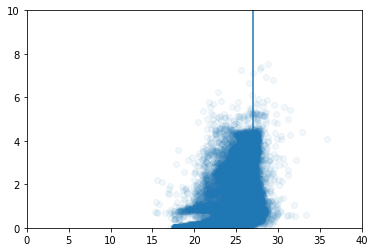

In [36]:
field='COSMOS'
df =  pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                    dtype={'ZSPEC_R':object})
plt.scatter(df.loc[ (df['ZPHOT_PEAK']>0.5) & (df['ZPHOT_PEAK']<3) & (df['MASS']>9.6),'HSC_i_MAG_AUTO'], 
            df.loc[ (df['ZPHOT_PEAK']>0.5) & (df['ZPHOT_PEAK']<3) & (df['MASS']>9.6),'SIG_DIFF'], alpha=0.06)
# plt.plot([0,15],[27,27])
plt.plot([27, 27], [0,10])
plt.xlim(0,40)
plt.ylim(0,10) # well I still gotta test the coverage of i band in COSMOS...

# yeah, I still say do a cut at 27... don't think it'll really make much of a difference
# let's try it...